In [1]:
from os import listdir
from os.path import join, isfile
import trimesh
import numpy as np #1.16.4 otherwise futurewarning tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import csv
from tqdm import tqdm
from sklearn.model_selection import LeaveOneOut
import cv2

In [2]:
NUM_CLASSES = 11
BATCH_SIZE = 8
NUM_POINTS = 510

# Data

In [3]:
def load_data():
    data = []
    labels = []

    GENERAL_DIR = r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien" 
    syn_list = ['ADNP', 'ANKRD11', 'CDK13', 'DEAF1', 'DYRK1A', 'EHMT1', 'FBXO11', 'SON', 'WAC', 'YY1', 'KDVS']
    file = GENERAL_DIR+ "\\features_facereader_landmarks_patient_groups.csv"
    class_map = {}
    
    for index, syn in enumerate(syn_list):
        class_map[index] = syn
        
        files = [f for f in listdir(GENERAL_DIR +"\\{}\\{}-all-photos".format(syn, syn)) if "jpg" in f]

        with open(file, newline='') as csvfile:
            reader = csv.reader(csvfile, delimiter=',')
            for row in reader:
                if row[0] in files:
                    fr_rep = [float(f) for f in row[1:]]
                    if not all(v == 0 for v in fr_rep):

                        rep = []
                        i = 1
                        while i < len(row[1:]):
                            rep.append([float(row[i]), float(row[i+1]), float(row[i+2])])
                            i+=3  
                        data.append(rep)
                        labels.append(index)
                        
    
    return np.array(data), np.array(labels), class_map

In [4]:
def augment(points, label):
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    points = tf.random.shuffle(points)
    return points, label

(221, 510, 3)
(221,)


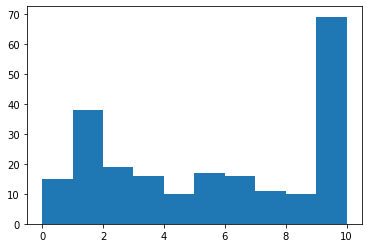

In [5]:
data, labels, class_map = load_data()

print(data.shape)
print(labels.shape)

plt.hist(labels)
plt.show()

# Model

In [6]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding='valid')(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [7]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)
        
    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2,2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

In [8]:
def tnet(inputs, num_features):
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)
    
    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features, 
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg)(x)
    
    feat_T = layers.Reshape((num_features, num_features))(x)
    
    return layers.Dot(axes=(2,1))([inputs, feat_T])

In [9]:
# model

inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(rate=0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(rate=0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 510, 3)       0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 510, 32)      128         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 510, 32)      128         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activatio

In [10]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=["sparse_categorical_accuracy"])

# Training

In [11]:
def gradCAM(model, X_test, y_test, intensity=0.5, res=250):
    
#     fig = plt.figure()
#     ax = fig.gca(projection='3d')
#     print
#     ax.plot(X_test[0][:][0], X_test[0][:][1], X_test[0][:][2])
#     ax.legend()
#     plt.show()

    y_pred_array = model.predict(X_test)
    y_pred = tf.math.argmax(y_pred_array, -1).eval(session=tf.Session())
    
    with tf.GradientTape() as tape:
        last_conv_layer = model.layers[-13]
        iterate = tf.keras.Model([model.inputs], [model.output, last_conv_layer.output])
        model_out, last_conv_layer = iterate(X_test)
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
        
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = heatmap.reshape((8,8))
    
    cv2.imshow(cv2.resize(heatmap, (res, res)))

In [ ]:
predictions = []
predictions_probs = []

loo = LeaveOneOut()
i = 0
for train_index, test_index in tqdm(loo.split(data)):
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
    model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet{}".format(i))
    model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=["sparse_categorical_accuracy"])
   
    model.fit(x=X_train, y=y_train, batch_size=BATCH_SIZE, epochs=10, shuffle=True)
    
    y_pred_array = model.predict(X_test)
    y_pred = tf.math.argmax(y_pred_array, -1).eval(session=tf.Session())
    
    predictions.append([y_test[0], y_pred[0]])
    predictions_probs.append([y_test[0], y_pred_array[0]])
    
    #gradCAM(model, X_test, y_test)
    
    i+=1
    

0it [00:00, ?it/s]

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/10
220/220 [==============================] - 13s 58ms/sample - loss: 3.2985 - sparse_categorical_accuracy: 0.2455
Epoch 2/10
220/220 [==============================] - 11s 48ms/sample - loss: 2.9111 - sparse_categorical_accuracy: 0.2909
Epoch 3/10
220/220 [==============================] - 11s 48ms/sample - loss: 2.7085 - sparse_categorical_accuracy: 0.2773
Epoch 4/10
220/220 [==============================] - 11s 48ms/sample - loss: 2.5223 - sparse_categorical_accuracy: 0.3273
Epoch 5/10
220/220 [==============================] - 11s 49ms/sample - loss: 2.3995 - sparse_categorical_accuracy: 0.3182
Epoch 6/10
220/220 [==============================] - 11s 48ms/sample - loss: 2.4900 - sparse_categorical_accuracy: 0.3227
Epoch 7/10
220/220 [==============================] - 11s 48ms/sample - loss: 2.4279 - sparse_categorical_accuracy: 0.3727
Epoch 8/10
22

1it [01:55, 115.48s/it]

Epoch 1/10
220/220 [==============================] - 13s 58ms/sample - loss: 2.4147 - sparse_categorical_accuracy: 0.3545
Epoch 2/10
220/220 [==============================] - 11s 48ms/sample - loss: 2.2851 - sparse_categorical_accuracy: 0.3636
Epoch 3/10
220/220 [==============================] - 11s 49ms/sample - loss: 2.4036 - sparse_categorical_accuracy: 0.3318
Epoch 4/10
220/220 [==============================] - 11s 48ms/sample - loss: 2.4132 - sparse_categorical_accuracy: 0.3182
Epoch 5/10
220/220 [==============================] - 11s 49ms/sample - loss: 2.3042 - sparse_categorical_accuracy: 0.3773
Epoch 6/10
220/220 [==============================] - 11s 48ms/sample - loss: 2.3600 - sparse_categorical_accuracy: 0.3591
Epoch 7/10
220/220 [==============================] - 11s 48ms/sample - loss: 2.3144 - sparse_categorical_accuracy: 0.3773
Epoch 8/10
220/220 [==============================] - 11s 48ms/sample - loss: 2.3680 - sparse_categorical_accuracy: 0.3727
Epoch 9/10
220/2

2it [03:51, 115.70s/it]

Epoch 1/10
220/220 [==============================] - 13s 58ms/sample - loss: 2.3696 - sparse_categorical_accuracy: 0.3818
Epoch 2/10
220/220 [==============================] - 11s 48ms/sample - loss: 2.2531 - sparse_categorical_accuracy: 0.3727
Epoch 3/10
220/220 [==============================] - 11s 48ms/sample - loss: 2.2488 - sparse_categorical_accuracy: 0.3773
Epoch 4/10
220/220 [==============================] - 11s 48ms/sample - loss: 2.3021 - sparse_categorical_accuracy: 0.3409
Epoch 5/10
220/220 [==============================] - 11s 48ms/sample - loss: 2.2053 - sparse_categorical_accuracy: 0.3500
Epoch 6/10
220/220 [==============================] - 11s 49ms/sample - loss: 2.1918 - sparse_categorical_accuracy: 0.3591
Epoch 7/10
220/220 [==============================] - 11s 48ms/sample - loss: 2.1724 - sparse_categorical_accuracy: 0.3727
Epoch 8/10
220/220 [==============================] - 11s 48ms/sample - loss: 2.2643 - sparse_categorical_accuracy: 0.3636
Epoch 9/10
220/2

3it [05:48, 116.05s/it]

Epoch 1/10
220/220 [==============================] - 13s 59ms/sample - loss: 2.2737 - sparse_categorical_accuracy: 0.3909
Epoch 2/10
220/220 [==============================] - 11s 48ms/sample - loss: 2.2931 - sparse_categorical_accuracy: 0.3591
Epoch 3/10
220/220 [==============================] - 11s 48ms/sample - loss: 2.2813 - sparse_categorical_accuracy: 0.3773
Epoch 4/10
220/220 [==============================] - 11s 48ms/sample - loss: 2.3480 - sparse_categorical_accuracy: 0.3727
Epoch 5/10
220/220 [==============================] - 11s 48ms/sample - loss: 2.1839 - sparse_categorical_accuracy: 0.3955
Epoch 6/10
220/220 [==============================] - 11s 49ms/sample - loss: 2.1388 - sparse_categorical_accuracy: 0.4045
Epoch 7/10
220/220 [==============================] - 11s 48ms/sample - loss: 2.1521 - sparse_categorical_accuracy: 0.3955
Epoch 8/10
220/220 [==============================] - 11s 49ms/sample - loss: 2.0957 - sparse_categorical_accuracy: 0.4227
Epoch 9/10
220/2

4it [07:47, 116.82s/it]

Epoch 1/10
220/220 [==============================] - 13s 60ms/sample - loss: 2.2042 - sparse_categorical_accuracy: 0.4045
Epoch 2/10
220/220 [==============================] - 11s 49ms/sample - loss: 2.1881 - sparse_categorical_accuracy: 0.4045
Epoch 3/10
220/220 [==============================] - 11s 48ms/sample - loss: 2.1929 - sparse_categorical_accuracy: 0.3864
Epoch 4/10
220/220 [==============================] - 11s 48ms/sample - loss: 2.1646 - sparse_categorical_accuracy: 0.4227
Epoch 5/10
220/220 [==============================] - 11s 49ms/sample - loss: 2.2446 - sparse_categorical_accuracy: 0.3909
Epoch 6/10
220/220 [==============================] - 11s 49ms/sample - loss: 2.2369 - sparse_categorical_accuracy: 0.3591
Epoch 7/10
220/220 [==============================] - 11s 48ms/sample - loss: 2.7307 - sparse_categorical_accuracy: 0.3727
Epoch 8/10
220/220 [==============================] - 11s 49ms/sample - loss: 2.4579 - sparse_categorical_accuracy: 0.3500
Epoch 9/10
220/2

5it [09:46, 117.65s/it]

Epoch 1/10
220/220 [==============================] - 13s 60ms/sample - loss: 2.3033 - sparse_categorical_accuracy: 0.3864
Epoch 2/10
220/220 [==============================] - 11s 50ms/sample - loss: 2.1601 - sparse_categorical_accuracy: 0.3682
Epoch 3/10
220/220 [==============================] - 11s 49ms/sample - loss: 2.2007 - sparse_categorical_accuracy: 0.3591
Epoch 4/10
220/220 [==============================] - 11s 49ms/sample - loss: 2.4054 - sparse_categorical_accuracy: 0.3227
Epoch 5/10
220/220 [==============================] - 11s 49ms/sample - loss: 2.2301 - sparse_categorical_accuracy: 0.4091
Epoch 6/10
220/220 [==============================] - 11s 49ms/sample - loss: 2.2413 - sparse_categorical_accuracy: 0.3909
Epoch 7/10
220/220 [==============================] - 11s 49ms/sample - loss: 2.2502 - sparse_categorical_accuracy: 0.3682
Epoch 8/10
220/220 [==============================] - 11s 49ms/sample - loss: 2.2743 - sparse_categorical_accuracy: 0.3955
Epoch 9/10
220/2

6it [11:47, 118.69s/it]

Epoch 1/10
220/220 [==============================] - 13s 60ms/sample - loss: 2.4877 - sparse_categorical_accuracy: 0.3455
Epoch 2/10
220/220 [==============================] - 11s 49ms/sample - loss: 2.2553 - sparse_categorical_accuracy: 0.3727
Epoch 3/10
220/220 [==============================] - 11s 49ms/sample - loss: 2.2095 - sparse_categorical_accuracy: 0.4045
Epoch 4/10
220/220 [==============================] - 11s 49ms/sample - loss: 2.2006 - sparse_categorical_accuracy: 0.4000
Epoch 5/10
220/220 [==============================] - 11s 49ms/sample - loss: 2.2682 - sparse_categorical_accuracy: 0.3909
Epoch 6/10
220/220 [==============================] - 11s 49ms/sample - loss: 2.2168 - sparse_categorical_accuracy: 0.3864
Epoch 7/10
220/220 [==============================] - 11s 49ms/sample - loss: 2.1242 - sparse_categorical_accuracy: 0.4000
Epoch 8/10
220/220 [==============================] - 11s 49ms/sample - loss: 2.1428 - sparse_categorical_accuracy: 0.4045
Epoch 9/10
220/2

7it [13:49, 119.67s/it]

Epoch 1/10
220/220 [==============================] - 13s 60ms/sample - loss: 2.1540 - sparse_categorical_accuracy: 0.4045
Epoch 2/10
220/220 [==============================] - 11s 49ms/sample - loss: 2.0906 - sparse_categorical_accuracy: 0.4000
Epoch 3/10
220/220 [==============================] - 11s 49ms/sample - loss: 2.0496 - sparse_categorical_accuracy: 0.4136
Epoch 4/10
220/220 [==============================] - 11s 49ms/sample - loss: 2.1692 - sparse_categorical_accuracy: 0.3955
Epoch 5/10
220/220 [==============================] - 11s 49ms/sample - loss: 2.1163 - sparse_categorical_accuracy: 0.3909
Epoch 6/10
220/220 [==============================] - 11s 49ms/sample - loss: 2.0950 - sparse_categorical_accuracy: 0.4000
Epoch 7/10
220/220 [==============================] - 11s 50ms/sample - loss: 2.1310 - sparse_categorical_accuracy: 0.4136
Epoch 8/10
220/220 [==============================] - 11s 49ms/sample - loss: 2.1335 - sparse_categorical_accuracy: 0.3955
Epoch 9/10
220/2

8it [15:53, 120.87s/it]

Epoch 1/10
220/220 [==============================] - 13s 61ms/sample - loss: 2.2345 - sparse_categorical_accuracy: 0.4045
Epoch 2/10
220/220 [==============================] - 11s 49ms/sample - loss: 2.2046 - sparse_categorical_accuracy: 0.3909
Epoch 3/10
220/220 [==============================] - 11s 49ms/sample - loss: 2.1442 - sparse_categorical_accuracy: 0.4136
Epoch 4/10
220/220 [==============================] - 11s 49ms/sample - loss: 2.2001 - sparse_categorical_accuracy: 0.3727
Epoch 5/10
220/220 [==============================] - 11s 49ms/sample - loss: 2.1228 - sparse_categorical_accuracy: 0.3773
Epoch 6/10
220/220 [==============================] - 11s 50ms/sample - loss: 2.1154 - sparse_categorical_accuracy: 0.4000
Epoch 7/10
220/220 [==============================] - 11s 49ms/sample - loss: 2.1410 - sparse_categorical_accuracy: 0.4091
Epoch 8/10
220/220 [==============================] - 11s 49ms/sample - loss: 2.1141 - sparse_categorical_accuracy: 0.4000
Epoch 9/10
220/2

9it [17:58, 122.01s/it]

Epoch 1/10
220/220 [==============================] - 13s 61ms/sample - loss: 2.1163 - sparse_categorical_accuracy: 0.3955
Epoch 2/10
220/220 [==============================] - 11s 49ms/sample - loss: 2.0194 - sparse_categorical_accuracy: 0.4500
Epoch 3/10
220/220 [==============================] - 11s 49ms/sample - loss: 2.1781 - sparse_categorical_accuracy: 0.3818
Epoch 4/10
220/220 [==============================] - 11s 50ms/sample - loss: 2.1700 - sparse_categorical_accuracy: 0.4000
Epoch 5/10
220/220 [==============================] - 11s 49ms/sample - loss: 2.1304 - sparse_categorical_accuracy: 0.4000
Epoch 6/10
220/220 [==============================] - 11s 50ms/sample - loss: 2.1209 - sparse_categorical_accuracy: 0.4045
Epoch 7/10
220/220 [==============================] - 11s 50ms/sample - loss: 2.0487 - sparse_categorical_accuracy: 0.4045
Epoch 8/10
220/220 [==============================] - 11s 49ms/sample - loss: 2.0633 - sparse_categorical_accuracy: 0.4273
Epoch 9/10
220/2

10it [20:05, 123.61s/it]

Epoch 1/10
220/220 [==============================] - 14s 62ms/sample - loss: 2.0628 - sparse_categorical_accuracy: 0.4136
Epoch 2/10
220/220 [==============================] - 11s 50ms/sample - loss: 2.1246 - sparse_categorical_accuracy: 0.3818
Epoch 3/10
220/220 [==============================] - 11s 50ms/sample - loss: 2.1055 - sparse_categorical_accuracy: 0.4045
Epoch 4/10
220/220 [==============================] - 11s 50ms/sample - loss: 2.0697 - sparse_categorical_accuracy: 0.4136
Epoch 5/10
220/220 [==============================] - 11s 50ms/sample - loss: 2.0334 - sparse_categorical_accuracy: 0.4000
Epoch 6/10
220/220 [==============================] - 11s 50ms/sample - loss: 2.0925 - sparse_categorical_accuracy: 0.3909
Epoch 7/10
220/220 [==============================] - 11s 50ms/sample - loss: 2.1137 - sparse_categorical_accuracy: 0.4136
Epoch 8/10
220/220 [==============================] - 11s 50ms/sample - loss: 2.0966 - sparse_categorical_accuracy: 0.4182
Epoch 9/10
220/2

11it [22:14, 125.17s/it]

Epoch 1/10
220/220 [==============================] - 14s 62ms/sample - loss: 2.2206 - sparse_categorical_accuracy: 0.3909
Epoch 2/10
220/220 [==============================] - 11s 50ms/sample - loss: 2.0911 - sparse_categorical_accuracy: 0.4091
Epoch 3/10
220/220 [==============================] - 11s 50ms/sample - loss: 2.0353 - sparse_categorical_accuracy: 0.4273
Epoch 4/10
220/220 [==============================] - 11s 51ms/sample - loss: 2.0020 - sparse_categorical_accuracy: 0.4227
Epoch 5/10
220/220 [==============================] - 11s 51ms/sample - loss: 2.1832 - sparse_categorical_accuracy: 0.3864
Epoch 6/10
220/220 [==============================] - 11s 50ms/sample - loss: 2.0800 - sparse_categorical_accuracy: 0.4091
Epoch 7/10
220/220 [==============================] - 11s 50ms/sample - loss: 2.1115 - sparse_categorical_accuracy: 0.4182
Epoch 8/10
220/220 [==============================] - 11s 50ms/sample - loss: 2.0523 - sparse_categorical_accuracy: 0.4182
Epoch 9/10
220/2

12it [24:25, 126.87s/it]

Epoch 1/10
220/220 [==============================] - 14s 63ms/sample - loss: 2.0883 - sparse_categorical_accuracy: 0.4227
Epoch 2/10
220/220 [==============================] - 11s 51ms/sample - loss: 2.1162 - sparse_categorical_accuracy: 0.3909
Epoch 3/10
220/220 [==============================] - 11s 52ms/sample - loss: 2.1279 - sparse_categorical_accuracy: 0.3864
Epoch 4/10
220/220 [==============================] - 11s 51ms/sample - loss: 2.1041 - sparse_categorical_accuracy: 0.4000
Epoch 5/10
220/220 [==============================] - 11s 51ms/sample - loss: 2.0761 - sparse_categorical_accuracy: 0.3818
Epoch 6/10
220/220 [==============================] - 11s 51ms/sample - loss: 2.0758 - sparse_categorical_accuracy: 0.3909
Epoch 7/10
220/220 [==============================] - 11s 51ms/sample - loss: 2.0502 - sparse_categorical_accuracy: 0.4091
Epoch 8/10
220/220 [==============================] - 11s 51ms/sample - loss: 2.1652 - sparse_categorical_accuracy: 0.4000
Epoch 9/10
220/2

13it [26:39, 128.97s/it]

Epoch 1/10
220/220 [==============================] - 14s 63ms/sample - loss: 2.0954 - sparse_categorical_accuracy: 0.3909
Epoch 2/10
220/220 [==============================] - 11s 51ms/sample - loss: 2.0383 - sparse_categorical_accuracy: 0.4000
Epoch 3/10
220/220 [==============================] - 11s 51ms/sample - loss: 2.1683 - sparse_categorical_accuracy: 0.3727
Epoch 4/10
220/220 [==============================] - 11s 51ms/sample - loss: 2.0407 - sparse_categorical_accuracy: 0.4364
Epoch 5/10
220/220 [==============================] - 11s 51ms/sample - loss: 2.0291 - sparse_categorical_accuracy: 0.4227
Epoch 6/10
220/220 [==============================] - 11s 51ms/sample - loss: 2.0217 - sparse_categorical_accuracy: 0.4182
Epoch 7/10
220/220 [==============================] - 11s 51ms/sample - loss: 2.0687 - sparse_categorical_accuracy: 0.4182
Epoch 8/10
220/220 [==============================] - 11s 51ms/sample - loss: 2.0187 - sparse_categorical_accuracy: 0.4091
Epoch 9/10
220/2

14it [28:53, 130.62s/it]

Epoch 1/10
220/220 [==============================] - 14s 65ms/sample - loss: 2.1176 - sparse_categorical_accuracy: 0.4182
Epoch 2/10
220/220 [==============================] - 11s 51ms/sample - loss: 2.0789 - sparse_categorical_accuracy: 0.3909
Epoch 3/10
220/220 [==============================] - 11s 51ms/sample - loss: 2.0317 - sparse_categorical_accuracy: 0.4318
Epoch 4/10
220/220 [==============================] - 11s 51ms/sample - loss: 1.9700 - sparse_categorical_accuracy: 0.4136
Epoch 5/10
220/220 [==============================] - 11s 51ms/sample - loss: 2.0898 - sparse_categorical_accuracy: 0.4091
Epoch 6/10
220/220 [==============================] - 11s 51ms/sample - loss: 2.0100 - sparse_categorical_accuracy: 0.4136
Epoch 7/10
220/220 [==============================] - 11s 52ms/sample - loss: 2.0066 - sparse_categorical_accuracy: 0.4318
Epoch 8/10
220/220 [==============================] - 11s 51ms/sample - loss: 2.0350 - sparse_categorical_accuracy: 0.4136
Epoch 9/10
220/2

15it [31:10, 132.51s/it]

Epoch 1/10
220/220 [==============================] - 14s 65ms/sample - loss: 1.9931 - sparse_categorical_accuracy: 0.4273
Epoch 2/10
220/220 [==============================] - 11s 52ms/sample - loss: 2.0281 - sparse_categorical_accuracy: 0.4045
Epoch 3/10
220/220 [==============================] - 11s 52ms/sample - loss: 2.0236 - sparse_categorical_accuracy: 0.3773
Epoch 4/10
220/220 [==============================] - 11s 52ms/sample - loss: 2.0348 - sparse_categorical_accuracy: 0.4318
Epoch 5/10
220/220 [==============================] - 12s 53ms/sample - loss: 2.0936 - sparse_categorical_accuracy: 0.3955
Epoch 6/10
220/220 [==============================] - 11s 52ms/sample - loss: 1.9972 - sparse_categorical_accuracy: 0.4273
Epoch 7/10
220/220 [==============================] - 11s 52ms/sample - loss: 1.9571 - sparse_categorical_accuracy: 0.4091
Epoch 8/10
220/220 [==============================] - 11s 52ms/sample - loss: 2.0411 - sparse_categorical_accuracy: 0.4045
Epoch 9/10
220/2

16it [33:31, 134.94s/it]

Epoch 1/10
220/220 [==============================] - 14s 65ms/sample - loss: 1.9970 - sparse_categorical_accuracy: 0.4318
Epoch 2/10
220/220 [==============================] - 11s 52ms/sample - loss: 2.0045 - sparse_categorical_accuracy: 0.4091
Epoch 3/10
220/220 [==============================] - 12s 52ms/sample - loss: 1.9523 - sparse_categorical_accuracy: 0.4182
Epoch 4/10
220/220 [==============================] - 11s 52ms/sample - loss: 2.0161 - sparse_categorical_accuracy: 0.4409
Epoch 5/10
220/220 [==============================] - 11s 52ms/sample - loss: 2.0745 - sparse_categorical_accuracy: 0.4273
Epoch 6/10
220/220 [==============================] - 11s 52ms/sample - loss: 2.0938 - sparse_categorical_accuracy: 0.4182
Epoch 7/10
220/220 [==============================] - 11s 52ms/sample - loss: 2.0075 - sparse_categorical_accuracy: 0.4136
Epoch 8/10
220/220 [==============================] - 11s 52ms/sample - loss: 2.0300 - sparse_categorical_accuracy: 0.4136
Epoch 9/10
220/2

17it [35:52, 136.84s/it]

Epoch 1/10
220/220 [==============================] - 14s 66ms/sample - loss: 2.0599 - sparse_categorical_accuracy: 0.4136
Epoch 2/10
220/220 [==============================] - 12s 53ms/sample - loss: 2.0053 - sparse_categorical_accuracy: 0.4136
Epoch 3/10
220/220 [==============================] - 11s 52ms/sample - loss: 1.9595 - sparse_categorical_accuracy: 0.4318
Epoch 4/10
220/220 [==============================] - 11s 52ms/sample - loss: 2.0620 - sparse_categorical_accuracy: 0.4091
Epoch 5/10
220/220 [==============================] - 12s 52ms/sample - loss: 1.9723 - sparse_categorical_accuracy: 0.4227
Epoch 6/10
220/220 [==============================] - 12s 53ms/sample - loss: 1.9644 - sparse_categorical_accuracy: 0.4409
Epoch 7/10
220/220 [==============================] - 12s 53ms/sample - loss: 1.9932 - sparse_categorical_accuracy: 0.4136
Epoch 8/10
220/220 [==============================] - 12s 52ms/sample - loss: 2.0087 - sparse_categorical_accuracy: 0.3864
Epoch 9/10
220/2

18it [38:16, 138.93s/it]

Epoch 1/10
220/220 [==============================] - 15s 66ms/sample - loss: 2.1071 - sparse_categorical_accuracy: 0.4091
Epoch 2/10
220/220 [==============================] - 12s 53ms/sample - loss: 2.0529 - sparse_categorical_accuracy: 0.4273
Epoch 3/10
220/220 [==============================] - 12s 53ms/sample - loss: 1.9608 - sparse_categorical_accuracy: 0.4136
Epoch 4/10
220/220 [==============================] - 12s 53ms/sample - loss: 2.0009 - sparse_categorical_accuracy: 0.4091
Epoch 5/10
220/220 [==============================] - 12s 53ms/sample - loss: 1.9549 - sparse_categorical_accuracy: 0.4409
Epoch 6/10
220/220 [==============================] - 12s 53ms/sample - loss: 1.9742 - sparse_categorical_accuracy: 0.4045
Epoch 7/10
220/220 [==============================] - 12s 53ms/sample - loss: 1.9776 - sparse_categorical_accuracy: 0.4364
Epoch 8/10
220/220 [==============================] - 12s 53ms/sample - loss: 1.9730 - sparse_categorical_accuracy: 0.4409
Epoch 9/10
220/2

19it [40:42, 141.12s/it]

Epoch 1/10
220/220 [==============================] - 15s 67ms/sample - loss: 2.0626 - sparse_categorical_accuracy: 0.4409
Epoch 2/10
220/220 [==============================] - 12s 54ms/sample - loss: 1.9824 - sparse_categorical_accuracy: 0.4045
Epoch 3/10
220/220 [==============================] - 12s 53ms/sample - loss: 1.9926 - sparse_categorical_accuracy: 0.3818
Epoch 4/10
220/220 [==============================] - 12s 53ms/sample - loss: 1.9816 - sparse_categorical_accuracy: 0.4364
Epoch 5/10
220/220 [==============================] - 12s 53ms/sample - loss: 1.9863 - sparse_categorical_accuracy: 0.4182
Epoch 6/10
220/220 [==============================] - 12s 53ms/sample - loss: 1.9967 - sparse_categorical_accuracy: 0.3909
Epoch 7/10
220/220 [==============================] - 12s 53ms/sample - loss: 1.9331 - sparse_categorical_accuracy: 0.4591
Epoch 8/10
220/220 [==============================] - 12s 54ms/sample - loss: 2.0172 - sparse_categorical_accuracy: 0.4318
Epoch 9/10
220/2

20it [43:12, 143.76s/it]

Epoch 1/10
220/220 [==============================] - 15s 68ms/sample - loss: 1.9638 - sparse_categorical_accuracy: 0.4182
Epoch 2/10
220/220 [==============================] - 12s 54ms/sample - loss: 1.9929 - sparse_categorical_accuracy: 0.4045
Epoch 3/10
220/220 [==============================] - 12s 54ms/sample - loss: 1.9741 - sparse_categorical_accuracy: 0.4000
Epoch 4/10
220/220 [==============================] - 12s 53ms/sample - loss: 1.9780 - sparse_categorical_accuracy: 0.4318
Epoch 5/10
220/220 [==============================] - 12s 54ms/sample - loss: 2.0480 - sparse_categorical_accuracy: 0.3773
Epoch 6/10
220/220 [==============================] - 12s 53ms/sample - loss: 1.9088 - sparse_categorical_accuracy: 0.4091
Epoch 7/10
220/220 [==============================] - 12s 53ms/sample - loss: 1.9894 - sparse_categorical_accuracy: 0.3955
Epoch 8/10
220/220 [==============================] - 12s 54ms/sample - loss: 1.9459 - sparse_categorical_accuracy: 0.4409
Epoch 9/10
220/2

21it [45:43, 145.97s/it]

Epoch 1/10
220/220 [==============================] - 15s 68ms/sample - loss: 2.0082 - sparse_categorical_accuracy: 0.4182
Epoch 2/10
220/220 [==============================] - 12s 54ms/sample - loss: 1.9375 - sparse_categorical_accuracy: 0.4182
Epoch 3/10
220/220 [==============================] - 12s 55ms/sample - loss: 2.0263 - sparse_categorical_accuracy: 0.3955
Epoch 4/10
220/220 [==============================] - 12s 54ms/sample - loss: 1.9402 - sparse_categorical_accuracy: 0.4455
Epoch 5/10
220/220 [==============================] - 12s 54ms/sample - loss: 1.9972 - sparse_categorical_accuracy: 0.4409
Epoch 6/10
220/220 [==============================] - 12s 54ms/sample - loss: 1.9087 - sparse_categorical_accuracy: 0.4318
Epoch 7/10
220/220 [==============================] - 12s 54ms/sample - loss: 1.9767 - sparse_categorical_accuracy: 0.4455
Epoch 8/10
220/220 [==============================] - 12s 55ms/sample - loss: 1.9610 - sparse_categorical_accuracy: 0.4227
Epoch 9/10
220/2

22it [48:16, 148.21s/it]

Epoch 1/10
220/220 [==============================] - 15s 69ms/sample - loss: 1.9447 - sparse_categorical_accuracy: 0.4273
Epoch 2/10
220/220 [==============================] - 12s 54ms/sample - loss: 1.9370 - sparse_categorical_accuracy: 0.4273
Epoch 3/10
220/220 [==============================] - 12s 54ms/sample - loss: 1.9967 - sparse_categorical_accuracy: 0.4227
Epoch 4/10
220/220 [==============================] - 12s 54ms/sample - loss: 1.9033 - sparse_categorical_accuracy: 0.4409
Epoch 5/10
220/220 [==============================] - 12s 55ms/sample - loss: 1.9458 - sparse_categorical_accuracy: 0.4455
Epoch 6/10
220/220 [==============================] - 12s 54ms/sample - loss: 1.8817 - sparse_categorical_accuracy: 0.4636
Epoch 7/10
220/220 [==============================] - 12s 54ms/sample - loss: 1.9309 - sparse_categorical_accuracy: 0.4409
Epoch 8/10
220/220 [==============================] - 12s 54ms/sample - loss: 1.9714 - sparse_categorical_accuracy: 0.4136
Epoch 9/10
220/2

23it [50:52, 150.36s/it]

Epoch 1/10
220/220 [==============================] - 15s 69ms/sample - loss: 2.0201 - sparse_categorical_accuracy: 0.4273
Epoch 2/10
220/220 [==============================] - 12s 55ms/sample - loss: 1.9347 - sparse_categorical_accuracy: 0.4227
Epoch 3/10
220/220 [==============================] - 12s 55ms/sample - loss: 1.9069 - sparse_categorical_accuracy: 0.4409
Epoch 4/10
220/220 [==============================] - 12s 54ms/sample - loss: 1.8696 - sparse_categorical_accuracy: 0.4318
Epoch 5/10
220/220 [==============================] - 12s 55ms/sample - loss: 1.8898 - sparse_categorical_accuracy: 0.4273
Epoch 6/10
220/220 [==============================] - 12s 54ms/sample - loss: 2.0934 - sparse_categorical_accuracy: 0.4136
Epoch 7/10
220/220 [==============================] - 12s 55ms/sample - loss: 1.9551 - sparse_categorical_accuracy: 0.4182
Epoch 8/10
220/220 [==============================] - 12s 54ms/sample - loss: 1.8936 - sparse_categorical_accuracy: 0.4318
Epoch 9/10
220/2

24it [53:30, 152.70s/it]

Epoch 1/10
220/220 [==============================] - 16s 71ms/sample - loss: 1.9423 - sparse_categorical_accuracy: 0.4045
Epoch 2/10
220/220 [==============================] - 12s 56ms/sample - loss: 1.9429 - sparse_categorical_accuracy: 0.4409
Epoch 3/10
220/220 [==============================] - 12s 55ms/sample - loss: 2.0286 - sparse_categorical_accuracy: 0.3909
Epoch 4/10
220/220 [==============================] - 12s 56ms/sample - loss: 1.8732 - sparse_categorical_accuracy: 0.4682
Epoch 5/10
220/220 [==============================] - 12s 56ms/sample - loss: 1.9965 - sparse_categorical_accuracy: 0.4500
Epoch 6/10
220/220 [==============================] - 12s 56ms/sample - loss: 1.8941 - sparse_categorical_accuracy: 0.4273
Epoch 7/10
220/220 [==============================] - 12s 56ms/sample - loss: 1.8797 - sparse_categorical_accuracy: 0.4636
Epoch 8/10
220/220 [==============================] - 12s 56ms/sample - loss: 1.9232 - sparse_categorical_accuracy: 0.4182
Epoch 9/10
220/2

25it [56:13, 155.90s/it]

Epoch 1/10
220/220 [==============================] - 16s 71ms/sample - loss: 1.8976 - sparse_categorical_accuracy: 0.4273
Epoch 2/10
220/220 [==============================] - 12s 56ms/sample - loss: 1.9098 - sparse_categorical_accuracy: 0.4591
Epoch 3/10
220/220 [==============================] - 12s 56ms/sample - loss: 1.9342 - sparse_categorical_accuracy: 0.4091
Epoch 4/10
220/220 [==============================] - 12s 56ms/sample - loss: 1.9404 - sparse_categorical_accuracy: 0.4182
Epoch 5/10
220/220 [==============================] - 12s 56ms/sample - loss: 1.9209 - sparse_categorical_accuracy: 0.4364
Epoch 6/10
220/220 [==============================] - 12s 56ms/sample - loss: 1.8840 - sparse_categorical_accuracy: 0.4636
Epoch 7/10
220/220 [==============================] - 12s 56ms/sample - loss: 1.9274 - sparse_categorical_accuracy: 0.4318
Epoch 8/10
220/220 [==============================] - 12s 56ms/sample - loss: 1.8788 - sparse_categorical_accuracy: 0.4545
Epoch 9/10
220/2

26it [59:00, 159.18s/it]

Epoch 1/10
220/220 [==============================] - 16s 72ms/sample - loss: 1.9200 - sparse_categorical_accuracy: 0.4182
Epoch 2/10
220/220 [==============================] - 13s 57ms/sample - loss: 2.0068 - sparse_categorical_accuracy: 0.4318
Epoch 3/10
220/220 [==============================] - 12s 56ms/sample - loss: 1.8977 - sparse_categorical_accuracy: 0.4545
Epoch 4/10
220/220 [==============================] - 12s 56ms/sample - loss: 1.8855 - sparse_categorical_accuracy: 0.4591
Epoch 5/10
220/220 [==============================] - 12s 56ms/sample - loss: 1.8912 - sparse_categorical_accuracy: 0.4455
Epoch 6/10
220/220 [==============================] - 13s 57ms/sample - loss: 1.9000 - sparse_categorical_accuracy: 0.4636
Epoch 7/10
220/220 [==============================] - 12s 56ms/sample - loss: 1.8738 - sparse_categorical_accuracy: 0.4227
Epoch 8/10
220/220 [==============================] - 12s 56ms/sample - loss: 1.9090 - sparse_categorical_accuracy: 0.4273
Epoch 9/10
220/2

27it [1:01:47, 161.61s/it]

Epoch 1/10
220/220 [==============================] - 16s 72ms/sample - loss: 1.8433 - sparse_categorical_accuracy: 0.4636
Epoch 2/10
220/220 [==============================] - 12s 56ms/sample - loss: 1.9632 - sparse_categorical_accuracy: 0.4318
Epoch 3/10
220/220 [==============================] - 13s 57ms/sample - loss: 1.9858 - sparse_categorical_accuracy: 0.4091
Epoch 4/10
220/220 [==============================] - 12s 57ms/sample - loss: 1.8908 - sparse_categorical_accuracy: 0.4318
Epoch 5/10
220/220 [==============================] - 12s 56ms/sample - loss: 1.8492 - sparse_categorical_accuracy: 0.4409
Epoch 6/10
220/220 [==============================] - 12s 57ms/sample - loss: 1.9016 - sparse_categorical_accuracy: 0.4500
Epoch 7/10
220/220 [==============================] - 12s 57ms/sample - loss: 1.9112 - sparse_categorical_accuracy: 0.4409
Epoch 8/10
220/220 [==============================] - 13s 57ms/sample - loss: 1.8755 - sparse_categorical_accuracy: 0.4182
Epoch 9/10
220/2

28it [1:04:37, 163.97s/it]

Epoch 1/10
220/220 [==============================] - 16s 73ms/sample - loss: 1.9587 - sparse_categorical_accuracy: 0.4591
Epoch 2/10
220/220 [==============================] - 13s 57ms/sample - loss: 1.8907 - sparse_categorical_accuracy: 0.4455
Epoch 3/10
220/220 [==============================] - 13s 57ms/sample - loss: 1.8797 - sparse_categorical_accuracy: 0.4545
Epoch 4/10
220/220 [==============================] - 13s 57ms/sample - loss: 1.8494 - sparse_categorical_accuracy: 0.4682
Epoch 5/10
220/220 [==============================] - 13s 57ms/sample - loss: 1.9326 - sparse_categorical_accuracy: 0.4045
Epoch 6/10
220/220 [==============================] - 13s 57ms/sample - loss: 1.8346 - sparse_categorical_accuracy: 0.4136
Epoch 7/10
220/220 [==============================] - 13s 57ms/sample - loss: 1.8055 - sparse_categorical_accuracy: 0.4636
Epoch 8/10
220/220 [==============================] - 13s 58ms/sample - loss: 1.9169 - sparse_categorical_accuracy: 0.4455
Epoch 9/10
220/2

29it [1:07:29, 166.49s/it]

Epoch 1/10
220/220 [==============================] - 16s 73ms/sample - loss: 1.9260 - sparse_categorical_accuracy: 0.4364
Epoch 2/10
220/220 [==============================] - 13s 57ms/sample - loss: 1.8933 - sparse_categorical_accuracy: 0.4000
Epoch 3/10
220/220 [==============================] - 12s 57ms/sample - loss: 1.8818 - sparse_categorical_accuracy: 0.4545
Epoch 4/10
220/220 [==============================] - 13s 57ms/sample - loss: 1.8856 - sparse_categorical_accuracy: 0.4273
Epoch 5/10
220/220 [==============================] - 13s 57ms/sample - loss: 1.8209 - sparse_categorical_accuracy: 0.4727
Epoch 6/10
220/220 [==============================] - 13s 57ms/sample - loss: 1.8685 - sparse_categorical_accuracy: 0.4227
Epoch 7/10
220/220 [==============================] - 13s 57ms/sample - loss: 1.8470 - sparse_categorical_accuracy: 0.4318
Epoch 8/10
220/220 [==============================] - 13s 57ms/sample - loss: 1.9426 - sparse_categorical_accuracy: 0.4636
Epoch 9/10
220/2

30it [1:10:23, 168.68s/it]

Epoch 1/10
220/220 [==============================] - 16s 75ms/sample - loss: 1.8743 - sparse_categorical_accuracy: 0.4455
Epoch 2/10
220/220 [==============================] - 13s 58ms/sample - loss: 1.8576 - sparse_categorical_accuracy: 0.4455
Epoch 3/10
220/220 [==============================] - 13s 58ms/sample - loss: 1.8870 - sparse_categorical_accuracy: 0.4455
Epoch 4/10
220/220 [==============================] - 13s 58ms/sample - loss: 1.9857 - sparse_categorical_accuracy: 0.4136
Epoch 5/10
220/220 [==============================] - 13s 59ms/sample - loss: 1.7731 - sparse_categorical_accuracy: 0.4545
Epoch 6/10
220/220 [==============================] - 13s 58ms/sample - loss: 1.8720 - sparse_categorical_accuracy: 0.4273
Epoch 7/10
220/220 [==============================] - 13s 58ms/sample - loss: 1.9198 - sparse_categorical_accuracy: 0.4273
Epoch 8/10
220/220 [==============================] - 13s 58ms/sample - loss: 1.9578 - sparse_categorical_accuracy: 0.4318
Epoch 9/10
220/2

31it [1:13:23, 172.11s/it]

Epoch 1/10
220/220 [==============================] - 17s 76ms/sample - loss: 1.9792 - sparse_categorical_accuracy: 0.4136
Epoch 2/10
220/220 [==============================] - 13s 59ms/sample - loss: 1.9542 - sparse_categorical_accuracy: 0.4636
Epoch 3/10
220/220 [==============================] - 13s 59ms/sample - loss: 1.8454 - sparse_categorical_accuracy: 0.4455
Epoch 4/10
220/220 [==============================] - 13s 59ms/sample - loss: 1.9400 - sparse_categorical_accuracy: 0.4545
Epoch 5/10
220/220 [==============================] - 13s 60ms/sample - loss: 1.8318 - sparse_categorical_accuracy: 0.4682
Epoch 6/10
220/220 [==============================] - 13s 59ms/sample - loss: 1.7914 - sparse_categorical_accuracy: 0.4591
Epoch 7/10
220/220 [==============================] - 13s 59ms/sample - loss: 1.8285 - sparse_categorical_accuracy: 0.4318
Epoch 8/10
220/220 [==============================] - 13s 59ms/sample - loss: 1.9799 - sparse_categorical_accuracy: 0.4091
Epoch 9/10
220/2

32it [1:16:26, 175.32s/it]

Epoch 1/10
220/220 [==============================] - 17s 77ms/sample - loss: 1.8643 - sparse_categorical_accuracy: 0.4591
Epoch 2/10
220/220 [==============================] - 13s 60ms/sample - loss: 1.7763 - sparse_categorical_accuracy: 0.4773
Epoch 3/10
220/220 [==============================] - 13s 60ms/sample - loss: 1.8887 - sparse_categorical_accuracy: 0.4727
Epoch 4/10
220/220 [==============================] - 13s 60ms/sample - loss: 1.7982 - sparse_categorical_accuracy: 0.4409
Epoch 5/10
220/220 [==============================] - 13s 60ms/sample - loss: 1.7996 - sparse_categorical_accuracy: 0.4818
Epoch 6/10
220/220 [==============================] - 13s 60ms/sample - loss: 1.8205 - sparse_categorical_accuracy: 0.4773
Epoch 7/10
220/220 [==============================] - 13s 60ms/sample - loss: 1.8247 - sparse_categorical_accuracy: 0.4636
Epoch 8/10
220/220 [==============================] - 13s 60ms/sample - loss: 1.9001 - sparse_categorical_accuracy: 0.4045
Epoch 9/10
220/2

33it [1:19:32, 178.64s/it]

Epoch 1/10
220/220 [==============================] - 17s 77ms/sample - loss: 1.7821 - sparse_categorical_accuracy: 0.4409
Epoch 2/10
220/220 [==============================] - 13s 59ms/sample - loss: 2.0300 - sparse_categorical_accuracy: 0.4364
Epoch 3/10
220/220 [==============================] - 13s 59ms/sample - loss: 1.9339 - sparse_categorical_accuracy: 0.4727
Epoch 4/10
220/220 [==============================] - 13s 60ms/sample - loss: 1.8371 - sparse_categorical_accuracy: 0.4409
Epoch 5/10
220/220 [==============================] - 13s 59ms/sample - loss: 1.8607 - sparse_categorical_accuracy: 0.4773
Epoch 6/10
220/220 [==============================] - 13s 59ms/sample - loss: 1.7772 - sparse_categorical_accuracy: 0.4727
Epoch 7/10
220/220 [==============================] - 13s 59ms/sample - loss: 1.8760 - sparse_categorical_accuracy: 0.4682
Epoch 8/10
220/220 [==============================] - 13s 59ms/sample - loss: 1.7865 - sparse_categorical_accuracy: 0.4955
Epoch 9/10
220/2

34it [1:22:40, 181.27s/it]

Epoch 1/10
220/220 [==============================] - 17s 77ms/sample - loss: 1.8158 - sparse_categorical_accuracy: 0.4682
Epoch 2/10
220/220 [==============================] - 13s 59ms/sample - loss: 1.8965 - sparse_categorical_accuracy: 0.4545
Epoch 3/10
220/220 [==============================] - 13s 60ms/sample - loss: 1.8075 - sparse_categorical_accuracy: 0.4591
Epoch 4/10
220/220 [==============================] - 13s 59ms/sample - loss: 1.9127 - sparse_categorical_accuracy: 0.4409
Epoch 5/10
220/220 [==============================] - 13s 59ms/sample - loss: 1.8445 - sparse_categorical_accuracy: 0.4364
Epoch 6/10
220/220 [==============================] - 13s 59ms/sample - loss: 1.8165 - sparse_categorical_accuracy: 0.4636
Epoch 7/10
220/220 [==============================] - 13s 59ms/sample - loss: 1.8614 - sparse_categorical_accuracy: 0.4636
Epoch 8/10
220/220 [==============================] - 13s 60ms/sample - loss: 1.9308 - sparse_categorical_accuracy: 0.4591
Epoch 9/10
220/2

35it [1:25:50, 183.95s/it]

Epoch 1/10
220/220 [==============================] - 17s 78ms/sample - loss: 1.9497 - sparse_categorical_accuracy: 0.4227
Epoch 2/10
220/220 [==============================] - 13s 60ms/sample - loss: 1.8840 - sparse_categorical_accuracy: 0.3955
Epoch 3/10
220/220 [==============================] - 13s 60ms/sample - loss: 1.8366 - sparse_categorical_accuracy: 0.4409
Epoch 4/10
220/220 [==============================] - 13s 60ms/sample - loss: 1.8119 - sparse_categorical_accuracy: 0.4500
Epoch 5/10
220/220 [==============================] - 13s 60ms/sample - loss: 1.8312 - sparse_categorical_accuracy: 0.4409
Epoch 6/10
220/220 [==============================] - 13s 60ms/sample - loss: 1.8559 - sparse_categorical_accuracy: 0.4545
Epoch 7/10
220/220 [==============================] - 13s 60ms/sample - loss: 1.8312 - sparse_categorical_accuracy: 0.4500
Epoch 8/10
220/220 [==============================] - 13s 60ms/sample - loss: 1.7852 - sparse_categorical_accuracy: 0.4727
Epoch 9/10
220/2

36it [1:29:03, 186.72s/it]

Epoch 1/10
220/220 [==============================] - 17s 78ms/sample - loss: 1.8078 - sparse_categorical_accuracy: 0.4773
Epoch 2/10
220/220 [==============================] - 13s 60ms/sample - loss: 1.8211 - sparse_categorical_accuracy: 0.4591
Epoch 3/10
220/220 [==============================] - 13s 60ms/sample - loss: 1.7942 - sparse_categorical_accuracy: 0.4864
Epoch 4/10
220/220 [==============================] - 13s 60ms/sample - loss: 1.7913 - sparse_categorical_accuracy: 0.4364
Epoch 5/10
220/220 [==============================] - 13s 60ms/sample - loss: 1.7914 - sparse_categorical_accuracy: 0.4545
Epoch 6/10
220/220 [==============================] - 13s 60ms/sample - loss: 1.8589 - sparse_categorical_accuracy: 0.4682
Epoch 7/10
220/220 [==============================] - 13s 60ms/sample - loss: 1.8708 - sparse_categorical_accuracy: 0.4409
Epoch 8/10
220/220 [==============================] - 13s 60ms/sample - loss: 1.7948 - sparse_categorical_accuracy: 0.4591
Epoch 9/10
220/2

37it [1:32:18, 189.09s/it]

Epoch 1/10
220/220 [==============================] - 18s 80ms/sample - loss: 1.9871 - sparse_categorical_accuracy: 0.4182
Epoch 2/10
220/220 [==============================] - 13s 61ms/sample - loss: 1.9178 - sparse_categorical_accuracy: 0.4227
Epoch 3/10
220/220 [==============================] - 13s 61ms/sample - loss: 1.8375 - sparse_categorical_accuracy: 0.4500
Epoch 4/10
220/220 [==============================] - 13s 61ms/sample - loss: 1.8136 - sparse_categorical_accuracy: 0.4727
Epoch 5/10
220/220 [==============================] - 14s 61ms/sample - loss: 1.8821 - sparse_categorical_accuracy: 0.4409
Epoch 6/10
220/220 [==============================] - 13s 61ms/sample - loss: 1.9934 - sparse_categorical_accuracy: 0.4273
Epoch 7/10
220/220 [==============================] - 13s 61ms/sample - loss: 1.9023 - sparse_categorical_accuracy: 0.4591
Epoch 8/10
220/220 [==============================] - 13s 61ms/sample - loss: 1.8800 - sparse_categorical_accuracy: 0.4818
Epoch 9/10
220/2

38it [1:35:43, 193.87s/it]

Epoch 1/10
220/220 [==============================] - 18s 82ms/sample - loss: 2.0148 - sparse_categorical_accuracy: 0.4227
Epoch 2/10
220/220 [==============================] - 14s 62ms/sample - loss: 1.8716 - sparse_categorical_accuracy: 0.4091
Epoch 3/10
220/220 [==============================] - 14s 63ms/sample - loss: 1.8087 - sparse_categorical_accuracy: 0.4773
Epoch 4/10
220/220 [==============================] - 14s 63ms/sample - loss: 1.8734 - sparse_categorical_accuracy: 0.4455
Epoch 5/10
220/220 [==============================] - 14s 62ms/sample - loss: 1.8790 - sparse_categorical_accuracy: 0.4682
Epoch 6/10
220/220 [==============================] - 14s 62ms/sample - loss: 1.7629 - sparse_categorical_accuracy: 0.4818
Epoch 7/10
220/220 [==============================] - 14s 63ms/sample - loss: 1.8044 - sparse_categorical_accuracy: 0.4727
Epoch 8/10
220/220 [==============================] - 14s 63ms/sample - loss: 1.9170 - sparse_categorical_accuracy: 0.4364
Epoch 9/10
220/2

39it [1:39:10, 197.91s/it]

Epoch 1/10
220/220 [==============================] - 18s 83ms/sample - loss: 1.7410 - sparse_categorical_accuracy: 0.4773
Epoch 2/10
220/220 [==============================] - 14s 63ms/sample - loss: 1.8447 - sparse_categorical_accuracy: 0.4818
Epoch 3/10
220/220 [==============================] - 14s 62ms/sample - loss: 1.8548 - sparse_categorical_accuracy: 0.4727
Epoch 4/10
220/220 [==============================] - 14s 62ms/sample - loss: 1.8653 - sparse_categorical_accuracy: 0.4591
Epoch 5/10
220/220 [==============================] - 14s 63ms/sample - loss: 1.8130 - sparse_categorical_accuracy: 0.4682
Epoch 6/10
220/220 [==============================] - 14s 62ms/sample - loss: 1.7290 - sparse_categorical_accuracy: 0.4864
Epoch 7/10
220/220 [==============================] - 14s 63ms/sample - loss: 1.8261 - sparse_categorical_accuracy: 0.4773
Epoch 8/10
220/220 [==============================] - 14s 62ms/sample - loss: 1.8068 - sparse_categorical_accuracy: 0.5000
Epoch 9/10
220/2

40it [1:42:40, 201.44s/it]

Epoch 1/10
220/220 [==============================] - 18s 83ms/sample - loss: 1.8662 - sparse_categorical_accuracy: 0.4773
Epoch 2/10
220/220 [==============================] - 14s 63ms/sample - loss: 1.7658 - sparse_categorical_accuracy: 0.4818
Epoch 3/10
220/220 [==============================] - 14s 64ms/sample - loss: 1.8472 - sparse_categorical_accuracy: 0.4818
Epoch 4/10
220/220 [==============================] - 14s 63ms/sample - loss: 1.8068 - sparse_categorical_accuracy: 0.4636
Epoch 5/10
220/220 [==============================] - 14s 63ms/sample - loss: 1.7517 - sparse_categorical_accuracy: 0.5000
Epoch 6/10
220/220 [==============================] - 14s 63ms/sample - loss: 1.7745 - sparse_categorical_accuracy: 0.4955
Epoch 7/10
220/220 [==============================] - 14s 63ms/sample - loss: 1.7894 - sparse_categorical_accuracy: 0.4227
Epoch 8/10
220/220 [==============================] - 14s 64ms/sample - loss: 1.7903 - sparse_categorical_accuracy: 0.5136
Epoch 9/10
220/2

41it [1:46:14, 205.19s/it]

Epoch 1/10
220/220 [==============================] - 18s 83ms/sample - loss: 1.8232 - sparse_categorical_accuracy: 0.4864
Epoch 2/10
220/220 [==============================] - 14s 63ms/sample - loss: 1.8414 - sparse_categorical_accuracy: 0.4591
Epoch 3/10
220/220 [==============================] - 14s 62ms/sample - loss: 1.9066 - sparse_categorical_accuracy: 0.4409
Epoch 4/10
220/220 [==============================] - 14s 62ms/sample - loss: 1.8516 - sparse_categorical_accuracy: 0.4818
Epoch 5/10
220/220 [==============================] - 14s 63ms/sample - loss: 1.7971 - sparse_categorical_accuracy: 0.4455
Epoch 6/10
220/220 [==============================] - 14s 62ms/sample - loss: 1.7895 - sparse_categorical_accuracy: 0.4909
Epoch 7/10
220/220 [==============================] - 14s 62ms/sample - loss: 1.8806 - sparse_categorical_accuracy: 0.4364
Epoch 8/10
220/220 [==============================] - 14s 62ms/sample - loss: 1.8371 - sparse_categorical_accuracy: 0.4591
Epoch 9/10
220/2

42it [1:49:47, 207.75s/it]

Epoch 1/10
220/220 [==============================] - 18s 84ms/sample - loss: 1.7791 - sparse_categorical_accuracy: 0.4909
Epoch 2/10
220/220 [==============================] - 14s 63ms/sample - loss: 1.7861 - sparse_categorical_accuracy: 0.4545
Epoch 3/10
220/220 [==============================] - 14s 64ms/sample - loss: 1.8310 - sparse_categorical_accuracy: 0.4591
Epoch 4/10
220/220 [==============================] - 14s 63ms/sample - loss: 1.7972 - sparse_categorical_accuracy: 0.4636
Epoch 5/10
220/220 [==============================] - 14s 63ms/sample - loss: 1.7993 - sparse_categorical_accuracy: 0.4591
Epoch 6/10
220/220 [==============================] - 14s 63ms/sample - loss: 1.7714 - sparse_categorical_accuracy: 0.4909
Epoch 7/10
220/220 [==============================] - 14s 64ms/sample - loss: 1.7940 - sparse_categorical_accuracy: 0.4500
Epoch 8/10
220/220 [==============================] - 14s 63ms/sample - loss: 1.7521 - sparse_categorical_accuracy: 0.4955
Epoch 9/10
220/2

43it [1:53:26, 211.01s/it]

Epoch 1/10
220/220 [==============================] - 18s 84ms/sample - loss: 1.8780 - sparse_categorical_accuracy: 0.4545
Epoch 2/10
220/220 [==============================] - 14s 63ms/sample - loss: 1.8389 - sparse_categorical_accuracy: 0.4455
Epoch 3/10
220/220 [==============================] - 14s 63ms/sample - loss: 1.7079 - sparse_categorical_accuracy: 0.5000
Epoch 4/10
220/220 [==============================] - 14s 63ms/sample - loss: 1.8372 - sparse_categorical_accuracy: 0.5000
Epoch 5/10
220/220 [==============================] - 14s 63ms/sample - loss: 1.7297 - sparse_categorical_accuracy: 0.4591
Epoch 6/10
220/220 [==============================] - 14s 62ms/sample - loss: 1.8204 - sparse_categorical_accuracy: 0.4727
Epoch 7/10
220/220 [==============================] - 14s 62ms/sample - loss: 1.8316 - sparse_categorical_accuracy: 0.4545
Epoch 8/10
220/220 [==============================] - 14s 62ms/sample - loss: 1.7657 - sparse_categorical_accuracy: 0.4591
Epoch 9/10
220/2

44it [1:57:06, 213.68s/it]

Epoch 1/10
220/220 [==============================] - 19s 84ms/sample - loss: 1.7346 - sparse_categorical_accuracy: 0.4818
Epoch 2/10
220/220 [==============================] - 14s 64ms/sample - loss: 1.8213 - sparse_categorical_accuracy: 0.4864
Epoch 3/10
220/220 [==============================] - 14s 63ms/sample - loss: 1.8291 - sparse_categorical_accuracy: 0.4545
Epoch 4/10
220/220 [==============================] - 14s 64ms/sample - loss: 1.8956 - sparse_categorical_accuracy: 0.4636
Epoch 5/10
220/220 [==============================] - 14s 64ms/sample - loss: 1.8191 - sparse_categorical_accuracy: 0.4591
Epoch 6/10
220/220 [==============================] - 14s 64ms/sample - loss: 1.8442 - sparse_categorical_accuracy: 0.4682
Epoch 7/10
220/220 [==============================] - 14s 63ms/sample - loss: 1.7887 - sparse_categorical_accuracy: 0.4864
Epoch 8/10
220/220 [==============================] - 14s 64ms/sample - loss: 1.8174 - sparse_categorical_accuracy: 0.4455
Epoch 9/10
220/2

45it [2:00:50, 216.88s/it]

Epoch 1/10
220/220 [==============================] - 19s 85ms/sample - loss: 1.9421 - sparse_categorical_accuracy: 0.4318
Epoch 2/10
220/220 [==============================] - 14s 64ms/sample - loss: 1.9230 - sparse_categorical_accuracy: 0.4318
Epoch 3/10
220/220 [==============================] - 14s 65ms/sample - loss: 1.7584 - sparse_categorical_accuracy: 0.4909
Epoch 4/10
220/220 [==============================] - 14s 64ms/sample - loss: 1.7545 - sparse_categorical_accuracy: 0.4864
Epoch 5/10
220/220 [==============================] - 14s 64ms/sample - loss: 1.8358 - sparse_categorical_accuracy: 0.4636
Epoch 6/10
220/220 [==============================] - 14s 64ms/sample - loss: 1.7317 - sparse_categorical_accuracy: 0.5136
Epoch 7/10
220/220 [==============================] - 14s 65ms/sample - loss: 1.8395 - sparse_categorical_accuracy: 0.4455
Epoch 8/10
220/220 [==============================] - 14s 64ms/sample - loss: 1.9324 - sparse_categorical_accuracy: 0.4273
Epoch 9/10
220/2

46it [2:04:38, 220.23s/it]

Epoch 1/10
220/220 [==============================] - 19s 86ms/sample - loss: 1.8400 - sparse_categorical_accuracy: 0.4682
Epoch 2/10
220/220 [==============================] - 14s 64ms/sample - loss: 1.8260 - sparse_categorical_accuracy: 0.4727
Epoch 3/10
220/220 [==============================] - 14s 64ms/sample - loss: 1.7901 - sparse_categorical_accuracy: 0.4591
Epoch 4/10
220/220 [==============================] - 14s 64ms/sample - loss: 1.8106 - sparse_categorical_accuracy: 0.4864
Epoch 5/10
220/220 [==============================] - 14s 64ms/sample - loss: 1.8156 - sparse_categorical_accuracy: 0.4818
Epoch 6/10
220/220 [==============================] - 14s 64ms/sample - loss: 1.8756 - sparse_categorical_accuracy: 0.4818
Epoch 7/10
220/220 [==============================] - 14s 64ms/sample - loss: 1.8079 - sparse_categorical_accuracy: 0.4818
Epoch 8/10
220/220 [==============================] - 14s 65ms/sample - loss: 1.7519 - sparse_categorical_accuracy: 0.4727
Epoch 9/10
220/2

47it [2:08:27, 222.73s/it]

Epoch 1/10
220/220 [==============================] - 21s 93ms/sample - loss: 1.8155 - sparse_categorical_accuracy: 0.4682
Epoch 2/10
220/220 [==============================] - 15s 66ms/sample - loss: 1.7693 - sparse_categorical_accuracy: 0.4818
Epoch 3/10
220/220 [==============================] - 15s 67ms/sample - loss: 1.7159 - sparse_categorical_accuracy: 0.4864
Epoch 4/10
220/220 [==============================] - 15s 66ms/sample - loss: 1.7236 - sparse_categorical_accuracy: 0.4591
Epoch 5/10
220/220 [==============================] - 15s 66ms/sample - loss: 1.7848 - sparse_categorical_accuracy: 0.4773
Epoch 6/10
220/220 [==============================] - 14s 66ms/sample - loss: 1.8098 - sparse_categorical_accuracy: 0.5273
Epoch 7/10
220/220 [==============================] - 15s 66ms/sample - loss: 1.7777 - sparse_categorical_accuracy: 0.5000
Epoch 8/10
220/220 [==============================] - 15s 66ms/sample - loss: 1.8553 - sparse_categorical_accuracy: 0.4682
Epoch 9/10
220/2

48it [2:13:50, 252.73s/it]

Epoch 1/10
220/220 [==============================] - 19s 88ms/sample - loss: 1.7704 - sparse_categorical_accuracy: 0.4636
Epoch 2/10
220/220 [==============================] - 14s 66ms/sample - loss: 1.8949 - sparse_categorical_accuracy: 0.4773
Epoch 3/10
220/220 [==============================] - 14s 65ms/sample - loss: 1.8176 - sparse_categorical_accuracy: 0.4455
Epoch 4/10
220/220 [==============================] - 14s 65ms/sample - loss: 1.8171 - sparse_categorical_accuracy: 0.4773
Epoch 5/10
220/220 [==============================] - 14s 65ms/sample - loss: 1.7583 - sparse_categorical_accuracy: 0.4818
Epoch 6/10
220/220 [==============================] - 14s 66ms/sample - loss: 1.6773 - sparse_categorical_accuracy: 0.5227
Epoch 7/10
220/220 [==============================] - 14s 65ms/sample - loss: 1.8274 - sparse_categorical_accuracy: 0.4545
Epoch 8/10
220/220 [==============================] - 14s 65ms/sample - loss: 1.8233 - sparse_categorical_accuracy: 0.4773
Epoch 9/10
220/2

49it [2:18:09, 254.61s/it]

Epoch 1/10
220/220 [==============================] - 20s 89ms/sample - loss: 1.7682 - sparse_categorical_accuracy: 0.5000
Epoch 2/10
220/220 [==============================] - 14s 65ms/sample - loss: 1.8630 - sparse_categorical_accuracy: 0.4500
Epoch 3/10
220/220 [==============================] - 14s 65ms/sample - loss: 1.8441 - sparse_categorical_accuracy: 0.4591
Epoch 4/10
220/220 [==============================] - 14s 65ms/sample - loss: 1.7607 - sparse_categorical_accuracy: 0.4727
Epoch 5/10
220/220 [==============================] - 14s 66ms/sample - loss: 1.7883 - sparse_categorical_accuracy: 0.4818
Epoch 6/10
220/220 [==============================] - 15s 66ms/sample - loss: 1.7390 - sparse_categorical_accuracy: 0.4864
Epoch 7/10
220/220 [==============================] - 14s 65ms/sample - loss: 1.7732 - sparse_categorical_accuracy: 0.4909
Epoch 8/10
220/220 [==============================] - 14s 65ms/sample - loss: 1.8472 - sparse_categorical_accuracy: 0.4682
Epoch 9/10
220/2

50it [2:22:13, 251.54s/it]

Epoch 1/10
220/220 [==============================] - 20s 91ms/sample - loss: 1.8307 - sparse_categorical_accuracy: 0.4909
Epoch 2/10
220/220 [==============================] - 15s 67ms/sample - loss: 1.8099 - sparse_categorical_accuracy: 0.4773
Epoch 3/10
220/220 [==============================] - 15s 67ms/sample - loss: 1.8000 - sparse_categorical_accuracy: 0.4773
Epoch 4/10
220/220 [==============================] - 15s 67ms/sample - loss: 1.7370 - sparse_categorical_accuracy: 0.4864
Epoch 5/10
220/220 [==============================] - 15s 67ms/sample - loss: 1.7418 - sparse_categorical_accuracy: 0.4727
Epoch 6/10
220/220 [==============================] - 15s 67ms/sample - loss: 1.8569 - sparse_categorical_accuracy: 0.4591
Epoch 7/10
220/220 [==============================] - 15s 67ms/sample - loss: 1.7069 - sparse_categorical_accuracy: 0.4773
Epoch 8/10
220/220 [==============================] - 15s 67ms/sample - loss: 1.7935 - sparse_categorical_accuracy: 0.4636
Epoch 9/10
220/2

51it [2:26:23, 251.15s/it]

Epoch 1/10
220/220 [==============================] - 20s 90ms/sample - loss: 1.8191 - sparse_categorical_accuracy: 0.4818
Epoch 2/10
220/220 [==============================] - 15s 66ms/sample - loss: 1.7341 - sparse_categorical_accuracy: 0.5000
Epoch 3/10
220/220 [==============================] - 15s 66ms/sample - loss: 1.8451 - sparse_categorical_accuracy: 0.4636
Epoch 4/10
220/220 [==============================] - 15s 67ms/sample - loss: 1.7565 - sparse_categorical_accuracy: 0.4773
Epoch 5/10
220/220 [==============================] - 15s 67ms/sample - loss: 1.7067 - sparse_categorical_accuracy: 0.4864
Epoch 6/10
220/220 [==============================] - 15s 66ms/sample - loss: 1.7475 - sparse_categorical_accuracy: 0.5136
Epoch 7/10
220/220 [==============================] - 15s 67ms/sample - loss: 1.7985 - sparse_categorical_accuracy: 0.4682
Epoch 8/10
220/220 [==============================] - 15s 67ms/sample - loss: 1.7031 - sparse_categorical_accuracy: 0.4636
Epoch 9/10
220/2

52it [2:30:34, 251.04s/it]

Epoch 1/10
220/220 [==============================] - 20s 91ms/sample - loss: 1.8136 - sparse_categorical_accuracy: 0.5045
Epoch 2/10
220/220 [==============================] - 15s 67ms/sample - loss: 1.7955 - sparse_categorical_accuracy: 0.4273
Epoch 3/10
220/220 [==============================] - 15s 67ms/sample - loss: 1.8006 - sparse_categorical_accuracy: 0.4636
Epoch 4/10
220/220 [==============================] - 15s 67ms/sample - loss: 1.7499 - sparse_categorical_accuracy: 0.4864
Epoch 5/10
220/220 [==============================] - 15s 67ms/sample - loss: 1.7077 - sparse_categorical_accuracy: 0.5000
Epoch 6/10
220/220 [==============================] - 15s 67ms/sample - loss: 1.7392 - sparse_categorical_accuracy: 0.5227
Epoch 7/10
220/220 [==============================] - 15s 67ms/sample - loss: 1.7049 - sparse_categorical_accuracy: 0.4818
Epoch 8/10
220/220 [==============================] - 15s 67ms/sample - loss: 1.7630 - sparse_categorical_accuracy: 0.4818
Epoch 9/10
220/2

53it [2:34:48, 252.05s/it]

Epoch 1/10
220/220 [==============================] - 20s 92ms/sample - loss: 1.8002 - sparse_categorical_accuracy: 0.4636
Epoch 2/10
220/220 [==============================] - 15s 68ms/sample - loss: 1.7237 - sparse_categorical_accuracy: 0.4955
Epoch 3/10
220/220 [==============================] - 15s 69ms/sample - loss: 1.7667 - sparse_categorical_accuracy: 0.5091
Epoch 4/10
220/220 [==============================] - 15s 68ms/sample - loss: 1.7930 - sparse_categorical_accuracy: 0.4682
Epoch 5/10
220/220 [==============================] - 15s 68ms/sample - loss: 1.7195 - sparse_categorical_accuracy: 0.4773
Epoch 6/10
220/220 [==============================] - 15s 68ms/sample - loss: 1.8641 - sparse_categorical_accuracy: 0.4727
Epoch 7/10
220/220 [==============================] - 15s 68ms/sample - loss: 1.7574 - sparse_categorical_accuracy: 0.4909
Epoch 8/10
220/220 [==============================] - 15s 68ms/sample - loss: 1.7274 - sparse_categorical_accuracy: 0.4773
Epoch 9/10
220/2

54it [2:39:10, 254.83s/it]

Epoch 1/10
220/220 [==============================] - 20s 92ms/sample - loss: 1.7574 - sparse_categorical_accuracy: 0.5182
Epoch 2/10
220/220 [==============================] - 15s 67ms/sample - loss: 1.7018 - sparse_categorical_accuracy: 0.5409
Epoch 3/10
220/220 [==============================] - 15s 67ms/sample - loss: 1.7136 - sparse_categorical_accuracy: 0.5000
Epoch 4/10
220/220 [==============================] - 15s 67ms/sample - loss: 1.7434 - sparse_categorical_accuracy: 0.4636
Epoch 5/10
220/220 [==============================] - 15s 69ms/sample - loss: 1.7750 - sparse_categorical_accuracy: 0.4636
Epoch 6/10
220/220 [==============================] - 15s 68ms/sample - loss: 1.6755 - sparse_categorical_accuracy: 0.5000
Epoch 7/10
220/220 [==============================] - 15s 67ms/sample - loss: 1.8249 - sparse_categorical_accuracy: 0.4364
Epoch 8/10
220/220 [==============================] - 15s 67ms/sample - loss: 1.8397 - sparse_categorical_accuracy: 0.4682
Epoch 9/10
220/2

55it [2:43:40, 259.51s/it]

Epoch 1/10
220/220 [==============================] - 20s 92ms/sample - loss: 1.8303 - sparse_categorical_accuracy: 0.4818
Epoch 2/10
220/220 [==============================] - 15s 68ms/sample - loss: 1.7882 - sparse_categorical_accuracy: 0.4773
Epoch 3/10
220/220 [==============================] - 15s 68ms/sample - loss: 1.7708 - sparse_categorical_accuracy: 0.4909
Epoch 4/10
220/220 [==============================] - 15s 68ms/sample - loss: 1.6939 - sparse_categorical_accuracy: 0.5045
Epoch 5/10
220/220 [==============================] - 15s 68ms/sample - loss: 1.7826 - sparse_categorical_accuracy: 0.5000
Epoch 6/10
220/220 [==============================] - 15s 68ms/sample - loss: 1.7496 - sparse_categorical_accuracy: 0.4818
Epoch 7/10
220/220 [==============================] - 15s 68ms/sample - loss: 1.7088 - sparse_categorical_accuracy: 0.5182
Epoch 8/10
220/220 [==============================] - 15s 68ms/sample - loss: 1.7499 - sparse_categorical_accuracy: 0.5136
Epoch 9/10
220/2

56it [2:48:05, 261.02s/it]

Epoch 1/10
220/220 [==============================] - 20s 91ms/sample - loss: 1.6832 - sparse_categorical_accuracy: 0.4818
Epoch 2/10
220/220 [==============================] - 15s 67ms/sample - loss: 1.8112 - sparse_categorical_accuracy: 0.4773
Epoch 3/10
220/220 [==============================] - 15s 67ms/sample - loss: 1.7667 - sparse_categorical_accuracy: 0.5045
Epoch 4/10
220/220 [==============================] - 15s 67ms/sample - loss: 1.7133 - sparse_categorical_accuracy: 0.5045
Epoch 5/10
220/220 [==============================] - 15s 67ms/sample - loss: 1.7845 - sparse_categorical_accuracy: 0.4955
Epoch 6/10
220/220 [==============================] - 15s 67ms/sample - loss: 1.7222 - sparse_categorical_accuracy: 0.5045
Epoch 7/10
220/220 [==============================] - 15s 67ms/sample - loss: 1.7507 - sparse_categorical_accuracy: 0.4955
Epoch 8/10
220/220 [==============================] - 15s 67ms/sample - loss: 1.6605 - sparse_categorical_accuracy: 0.5273
Epoch 9/10
220/2

57it [2:52:31, 262.68s/it]

Epoch 1/10
220/220 [==============================] - 21s 94ms/sample - loss: 1.7126 - sparse_categorical_accuracy: 0.4909
Epoch 2/10
220/220 [==============================] - 15s 69ms/sample - loss: 1.7374 - sparse_categorical_accuracy: 0.4955
Epoch 3/10
220/220 [==============================] - 15s 69ms/sample - loss: 1.8292 - sparse_categorical_accuracy: 0.5000
Epoch 4/10
220/220 [==============================] - 15s 69ms/sample - loss: 1.7902 - sparse_categorical_accuracy: 0.5045
Epoch 5/10
220/220 [==============================] - 15s 69ms/sample - loss: 1.7200 - sparse_categorical_accuracy: 0.5045
Epoch 6/10
220/220 [==============================] - 15s 69ms/sample - loss: 1.6194 - sparse_categorical_accuracy: 0.5273
Epoch 7/10
220/220 [==============================] - 15s 69ms/sample - loss: 1.7184 - sparse_categorical_accuracy: 0.4864
Epoch 8/10
220/220 [==============================] - 15s 69ms/sample - loss: 1.6422 - sparse_categorical_accuracy: 0.5091
Epoch 9/10
220/2

58it [2:57:06, 266.44s/it]

Epoch 1/10
220/220 [==============================] - 23s 103ms/sample - loss: 1.7887 - sparse_categorical_accuracy: 0.5045
Epoch 2/10
220/220 [==============================] - 16s 71ms/sample - loss: 1.7855 - sparse_categorical_accuracy: 0.4864
Epoch 3/10
220/220 [==============================] - 16s 71ms/sample - loss: 1.8075 - sparse_categorical_accuracy: 0.5000
Epoch 4/10
220/220 [==============================] - 16s 72ms/sample - loss: 1.8695 - sparse_categorical_accuracy: 0.4455
Epoch 5/10
220/220 [==============================] - 16s 71ms/sample - loss: 1.8618 - sparse_categorical_accuracy: 0.4636
Epoch 6/10
220/220 [==============================] - 16s 71ms/sample - loss: 1.7871 - sparse_categorical_accuracy: 0.4864
Epoch 7/10
220/220 [==============================] - 16s 72ms/sample - loss: 1.8397 - sparse_categorical_accuracy: 0.4682
Epoch 8/10
220/220 [==============================] - 16s 71ms/sample - loss: 1.7677 - sparse_categorical_accuracy: 0.4909
Epoch 9/10
220/

59it [3:05:37, 339.81s/it]

Epoch 1/10
220/220 [==============================] - 22s 99ms/sample - loss: 1.8378 - sparse_categorical_accuracy: 0.4727
Epoch 2/10
220/220 [==============================] - 16s 72ms/sample - loss: 1.7829 - sparse_categorical_accuracy: 0.4818
Epoch 3/10
220/220 [==============================] - 16s 72ms/sample - loss: 1.7624 - sparse_categorical_accuracy: 0.4864
Epoch 4/10
220/220 [==============================] - 16s 72ms/sample - loss: 1.7643 - sparse_categorical_accuracy: 0.5136
Epoch 5/10
220/220 [==============================] - 16s 72ms/sample - loss: 1.8348 - sparse_categorical_accuracy: 0.4909
Epoch 6/10
220/220 [==============================] - 16s 72ms/sample - loss: 1.8586 - sparse_categorical_accuracy: 0.4818
Epoch 7/10
220/220 [==============================] - 16s 73ms/sample - loss: 1.7306 - sparse_categorical_accuracy: 0.4682
Epoch 8/10
220/220 [==============================] - 16s 72ms/sample - loss: 1.7003 - sparse_categorical_accuracy: 0.5136
Epoch 9/10
220/2

60it [3:11:13, 338.63s/it]

Epoch 1/10
220/220 [==============================] - 22s 102ms/sample - loss: 1.7648 - sparse_categorical_accuracy: 0.4864
Epoch 2/10
220/220 [==============================] - 16s 73ms/sample - loss: 1.8223 - sparse_categorical_accuracy: 0.4909
Epoch 3/10
220/220 [==============================] - 16s 73ms/sample - loss: 1.6874 - sparse_categorical_accuracy: 0.5091
Epoch 4/10
220/220 [==============================] - 16s 73ms/sample - loss: 1.7304 - sparse_categorical_accuracy: 0.4955
Epoch 5/10
220/220 [==============================] - 16s 74ms/sample - loss: 1.6819 - sparse_categorical_accuracy: 0.5182
Epoch 6/10
220/220 [==============================] - 16s 73ms/sample - loss: 1.7145 - sparse_categorical_accuracy: 0.5045
Epoch 7/10
220/220 [==============================] - 16s 74ms/sample - loss: 1.6642 - sparse_categorical_accuracy: 0.5273
Epoch 8/10
220/220 [==============================] - 16s 73ms/sample - loss: 1.6739 - sparse_categorical_accuracy: 0.5227
Epoch 9/10
220/

61it [3:16:11, 326.21s/it]

Epoch 1/10
220/220 [==============================] - 22s 100ms/sample - loss: 1.6556 - sparse_categorical_accuracy: 0.5227
Epoch 2/10
220/220 [==============================] - 16s 72ms/sample - loss: 1.7231 - sparse_categorical_accuracy: 0.4955
Epoch 3/10
220/220 [==============================] - 16s 72ms/sample - loss: 1.6212 - sparse_categorical_accuracy: 0.5364
Epoch 4/10
220/220 [==============================] - 16s 72ms/sample - loss: 1.7154 - sparse_categorical_accuracy: 0.4909
Epoch 5/10
220/220 [==============================] - 16s 73ms/sample - loss: 1.8293 - sparse_categorical_accuracy: 0.4818
Epoch 6/10
220/220 [==============================] - 16s 72ms/sample - loss: 1.7903 - sparse_categorical_accuracy: 0.4864
Epoch 7/10
220/220 [==============================] - 16s 72ms/sample - loss: 1.7374 - sparse_categorical_accuracy: 0.4727
Epoch 8/10
220/220 [==============================] - 16s 72ms/sample - loss: 1.6993 - sparse_categorical_accuracy: 0.4955
Epoch 9/10
220/

62it [3:21:08, 317.48s/it]

Epoch 1/10
220/220 [==============================] - 23s 103ms/sample - loss: 1.7706 - sparse_categorical_accuracy: 0.5045
Epoch 2/10
220/220 [==============================] - 16s 74ms/sample - loss: 1.7383 - sparse_categorical_accuracy: 0.5045
Epoch 3/10
220/220 [==============================] - 16s 74ms/sample - loss: 1.7558 - sparse_categorical_accuracy: 0.4773
Epoch 4/10
220/220 [==============================] - 16s 74ms/sample - loss: 1.6189 - sparse_categorical_accuracy: 0.5045
Epoch 5/10
220/220 [==============================] - 16s 74ms/sample - loss: 1.7081 - sparse_categorical_accuracy: 0.5091
Epoch 6/10
220/220 [==============================] - 16s 74ms/sample - loss: 1.7847 - sparse_categorical_accuracy: 0.4818
Epoch 7/10
220/220 [==============================] - 16s 73ms/sample - loss: 1.7883 - sparse_categorical_accuracy: 0.5045
Epoch 8/10
220/220 [==============================] - 16s 73ms/sample - loss: 1.6701 - sparse_categorical_accuracy: 0.5136
Epoch 9/10
220/

63it [3:26:18, 315.19s/it]

Epoch 1/10
220/220 [==============================] - 22s 102ms/sample - loss: 1.7764 - sparse_categorical_accuracy: 0.4818
Epoch 2/10
220/220 [==============================] - 16s 73ms/sample - loss: 1.6790 - sparse_categorical_accuracy: 0.5091
Epoch 3/10
220/220 [==============================] - 16s 73ms/sample - loss: 1.7264 - sparse_categorical_accuracy: 0.5182
Epoch 4/10
220/220 [==============================] - 16s 74ms/sample - loss: 1.6983 - sparse_categorical_accuracy: 0.4955
Epoch 5/10
220/220 [==============================] - 16s 74ms/sample - loss: 1.7580 - sparse_categorical_accuracy: 0.4727
Epoch 6/10
220/220 [==============================] - 16s 74ms/sample - loss: 1.7280 - sparse_categorical_accuracy: 0.4818
Epoch 7/10
220/220 [==============================] - 16s 74ms/sample - loss: 1.6329 - sparse_categorical_accuracy: 0.5227
Epoch 8/10
220/220 [==============================] - 16s 74ms/sample - loss: 1.6788 - sparse_categorical_accuracy: 0.5182
Epoch 9/10
220/

64it [3:31:43, 318.15s/it]

Epoch 1/10
220/220 [==============================] - 22s 102ms/sample - loss: 1.7574 - sparse_categorical_accuracy: 0.4818
Epoch 2/10
220/220 [==============================] - 16s 74ms/sample - loss: 1.6823 - sparse_categorical_accuracy: 0.5000
Epoch 3/10
220/220 [==============================] - 16s 74ms/sample - loss: 1.6513 - sparse_categorical_accuracy: 0.5364
Epoch 4/10
220/220 [==============================] - 16s 73ms/sample - loss: 1.7795 - sparse_categorical_accuracy: 0.4500
Epoch 5/10
220/220 [==============================] - 16s 73ms/sample - loss: 1.7152 - sparse_categorical_accuracy: 0.5182
Epoch 6/10
220/220 [==============================] - 16s 74ms/sample - loss: 1.6391 - sparse_categorical_accuracy: 0.5273
Epoch 7/10
220/220 [==============================] - 16s 73ms/sample - loss: 1.7559 - sparse_categorical_accuracy: 0.4636
Epoch 8/10
220/220 [==============================] - 16s 73ms/sample - loss: 1.6251 - sparse_categorical_accuracy: 0.4955
Epoch 9/10
220/

65it [3:37:27, 325.90s/it]

Epoch 1/10
220/220 [==============================] - 23s 104ms/sample - loss: 1.7218 - sparse_categorical_accuracy: 0.5136
Epoch 2/10
220/220 [==============================] - 16s 74ms/sample - loss: 1.8324 - sparse_categorical_accuracy: 0.4818
Epoch 3/10
220/220 [==============================] - 16s 74ms/sample - loss: 1.6348 - sparse_categorical_accuracy: 0.5182
Epoch 4/10
220/220 [==============================] - 16s 74ms/sample - loss: 1.6630 - sparse_categorical_accuracy: 0.5455
Epoch 5/10
220/220 [==============================] - 16s 73ms/sample - loss: 1.8017 - sparse_categorical_accuracy: 0.5091
Epoch 6/10
220/220 [==============================] - 16s 74ms/sample - loss: 1.6431 - sparse_categorical_accuracy: 0.5045
Epoch 7/10
220/220 [==============================] - 16s 74ms/sample - loss: 1.7431 - sparse_categorical_accuracy: 0.5364
Epoch 8/10
220/220 [==============================] - 16s 74ms/sample - loss: 1.7760 - sparse_categorical_accuracy: 0.4682
Epoch 9/10
220/

66it [3:43:24, 335.50s/it]

Epoch 1/10
220/220 [==============================] - 23s 103ms/sample - loss: 1.7372 - sparse_categorical_accuracy: 0.4773
Epoch 2/10
220/220 [==============================] - 16s 74ms/sample - loss: 1.6565 - sparse_categorical_accuracy: 0.4909
Epoch 3/10
220/220 [==============================] - 16s 73ms/sample - loss: 1.6935 - sparse_categorical_accuracy: 0.5136
Epoch 4/10
220/220 [==============================] - 16s 73ms/sample - loss: 1.6750 - sparse_categorical_accuracy: 0.5364
Epoch 5/10
220/220 [==============================] - 16s 73ms/sample - loss: 1.6850 - sparse_categorical_accuracy: 0.5227
Epoch 6/10
220/220 [==============================] - 16s 74ms/sample - loss: 1.7982 - sparse_categorical_accuracy: 0.4864
Epoch 7/10
220/220 [==============================] - 16s 74ms/sample - loss: 1.8046 - sparse_categorical_accuracy: 0.4636
Epoch 8/10
220/220 [==============================] - 16s 74ms/sample - loss: 1.7610 - sparse_categorical_accuracy: 0.4909
Epoch 9/10
220/

67it [3:49:19, 341.14s/it]

Epoch 1/10
220/220 [==============================] - 23s 103ms/sample - loss: 1.8436 - sparse_categorical_accuracy: 0.4727
Epoch 2/10
220/220 [==============================] - 16s 74ms/sample - loss: 1.9011 - sparse_categorical_accuracy: 0.4500
Epoch 3/10
220/220 [==============================] - 16s 73ms/sample - loss: 1.8016 - sparse_categorical_accuracy: 0.4864
Epoch 4/10
220/220 [==============================] - 16s 74ms/sample - loss: 1.6490 - sparse_categorical_accuracy: 0.5136
Epoch 5/10
220/220 [==============================] - 16s 74ms/sample - loss: 1.7527 - sparse_categorical_accuracy: 0.5045
Epoch 6/10
220/220 [==============================] - 16s 75ms/sample - loss: 1.6313 - sparse_categorical_accuracy: 0.5636
Epoch 7/10
220/220 [==============================] - 16s 74ms/sample - loss: 1.5831 - sparse_categorical_accuracy: 0.5364
Epoch 8/10
220/220 [==============================] - 16s 74ms/sample - loss: 1.7205 - sparse_categorical_accuracy: 0.5000
Epoch 9/10
220/

68it [3:55:30, 350.11s/it]

Epoch 1/10
220/220 [==============================] - 25s 113ms/sample - loss: 1.6649 - sparse_categorical_accuracy: 0.4955
Epoch 2/10
220/220 [==============================] - 16s 74ms/sample - loss: 1.7168 - sparse_categorical_accuracy: 0.5091
Epoch 3/10
220/220 [==============================] - 16s 74ms/sample - loss: 1.6596 - sparse_categorical_accuracy: 0.5045
Epoch 4/10
220/220 [==============================] - 16s 75ms/sample - loss: 1.6763 - sparse_categorical_accuracy: 0.5000
Epoch 5/10
220/220 [==============================] - 16s 74ms/sample - loss: 1.6574 - sparse_categorical_accuracy: 0.5500
Epoch 6/10
220/220 [==============================] - 16s 74ms/sample - loss: 1.6136 - sparse_categorical_accuracy: 0.5182
Epoch 7/10
220/220 [==============================] - 16s 74ms/sample - loss: 1.6331 - sparse_categorical_accuracy: 0.5227
Epoch 8/10
220/220 [==============================] - 17s 76ms/sample - loss: 1.6984 - sparse_categorical_accuracy: 0.4682
Epoch 9/10
220/

69it [4:01:56, 360.96s/it]

Epoch 1/10
220/220 [==============================] - 24s 107ms/sample - loss: 1.7514 - sparse_categorical_accuracy: 0.4818
Epoch 2/10
220/220 [==============================] - 17s 77ms/sample - loss: 1.6752 - sparse_categorical_accuracy: 0.5091
Epoch 3/10
220/220 [==============================] - 17s 76ms/sample - loss: 1.7117 - sparse_categorical_accuracy: 0.5091
Epoch 4/10
220/220 [==============================] - 17s 76ms/sample - loss: 1.7410 - sparse_categorical_accuracy: 0.4955
Epoch 5/10
220/220 [==============================] - 17s 76ms/sample - loss: 1.6843 - sparse_categorical_accuracy: 0.4909
Epoch 6/10
220/220 [==============================] - 17s 77ms/sample - loss: 1.7223 - sparse_categorical_accuracy: 0.4909
Epoch 7/10
220/220 [==============================] - 17s 76ms/sample - loss: 1.6879 - sparse_categorical_accuracy: 0.4773
Epoch 8/10
220/220 [==============================] - 17s 76ms/sample - loss: 1.6785 - sparse_categorical_accuracy: 0.5273
Epoch 9/10
220/

70it [4:08:41, 374.02s/it]

Epoch 1/10
220/220 [==============================] - 24s 107ms/sample - loss: 1.6146 - sparse_categorical_accuracy: 0.5364
Epoch 2/10
220/220 [==============================] - 17s 76ms/sample - loss: 1.6683 - sparse_categorical_accuracy: 0.4682
Epoch 3/10
220/220 [==============================] - 17s 76ms/sample - loss: 1.6540 - sparse_categorical_accuracy: 0.4909
Epoch 4/10
220/220 [==============================] - 17s 76ms/sample - loss: 1.7827 - sparse_categorical_accuracy: 0.4727
Epoch 5/10
220/220 [==============================] - 17s 76ms/sample - loss: 1.7619 - sparse_categorical_accuracy: 0.5091
Epoch 6/10
220/220 [==============================] - 17s 77ms/sample - loss: 1.6265 - sparse_categorical_accuracy: 0.5409
Epoch 7/10
220/220 [==============================] - 17s 76ms/sample - loss: 1.6920 - sparse_categorical_accuracy: 0.5591
Epoch 8/10
220/220 [==============================] - 17s 76ms/sample - loss: 1.6935 - sparse_categorical_accuracy: 0.4909
Epoch 9/10
220/

71it [4:15:36, 386.49s/it]

Epoch 1/10
220/220 [==============================] - 24s 107ms/sample - loss: 1.7042 - sparse_categorical_accuracy: 0.5045
Epoch 2/10
220/220 [==============================] - 17s 75ms/sample - loss: 1.9036 - sparse_categorical_accuracy: 0.4591
Epoch 3/10
220/220 [==============================] - 17s 76ms/sample - loss: 1.6848 - sparse_categorical_accuracy: 0.4864
Epoch 4/10
220/220 [==============================] - 17s 75ms/sample - loss: 1.7504 - sparse_categorical_accuracy: 0.5091
Epoch 5/10
220/220 [==============================] - 16s 75ms/sample - loss: 1.7395 - sparse_categorical_accuracy: 0.4818
Epoch 6/10
220/220 [==============================] - 17s 76ms/sample - loss: 1.7036 - sparse_categorical_accuracy: 0.5091
Epoch 7/10
220/220 [==============================] - 16s 75ms/sample - loss: 1.7375 - sparse_categorical_accuracy: 0.4727
Epoch 8/10
220/220 [==============================] - 16s 75ms/sample - loss: 1.6504 - sparse_categorical_accuracy: 0.5545
Epoch 9/10
220/

72it [4:22:40, 397.74s/it]

Epoch 1/10
220/220 [==============================] - 25s 112ms/sample - loss: 1.7325 - sparse_categorical_accuracy: 0.5227
Epoch 2/10
220/220 [==============================] - 18s 80ms/sample - loss: 1.5845 - sparse_categorical_accuracy: 0.5182
Epoch 3/10
220/220 [==============================] - 17s 78ms/sample - loss: 1.6044 - sparse_categorical_accuracy: 0.5136
Epoch 4/10
220/220 [==============================] - 17s 78ms/sample - loss: 1.6577 - sparse_categorical_accuracy: 0.5136
Epoch 5/10
220/220 [==============================] - 17s 78ms/sample - loss: 1.7321 - sparse_categorical_accuracy: 0.5136
Epoch 6/10
220/220 [==============================] - 17s 79ms/sample - loss: 1.6701 - sparse_categorical_accuracy: 0.5136
Epoch 7/10
220/220 [==============================] - 17s 78ms/sample - loss: 1.6748 - sparse_categorical_accuracy: 0.5000
Epoch 8/10
220/220 [==============================] - 17s 78ms/sample - loss: 1.7008 - sparse_categorical_accuracy: 0.5091
Epoch 9/10
220/

73it [4:30:04, 411.60s/it]

Epoch 1/10
220/220 [==============================] - 26s 117ms/sample - loss: 1.7379 - sparse_categorical_accuracy: 0.5227
Epoch 2/10
220/220 [==============================] - 17s 79ms/sample - loss: 1.7194 - sparse_categorical_accuracy: 0.4591
Epoch 3/10
220/220 [==============================] - 18s 80ms/sample - loss: 1.6145 - sparse_categorical_accuracy: 0.5182
Epoch 4/10
220/220 [==============================] - 17s 79ms/sample - loss: 1.7167 - sparse_categorical_accuracy: 0.5091
Epoch 5/10
220/220 [==============================] - 17s 78ms/sample - loss: 1.6423 - sparse_categorical_accuracy: 0.5227
Epoch 6/10
220/220 [==============================] - 17s 79ms/sample - loss: 1.6895 - sparse_categorical_accuracy: 0.4727
Epoch 7/10
220/220 [==============================] - 17s 79ms/sample - loss: 1.7284 - sparse_categorical_accuracy: 0.5045
Epoch 8/10
220/220 [==============================] - 17s 79ms/sample - loss: 1.8221 - sparse_categorical_accuracy: 0.4955
Epoch 9/10
220/

74it [4:45:28, 565.16s/it]

Epoch 1/10
220/220 [==============================] - 26s 117ms/sample - loss: 1.6390 - sparse_categorical_accuracy: 0.5091
Epoch 2/10
220/220 [==============================] - 18s 82ms/sample - loss: 1.6973 - sparse_categorical_accuracy: 0.5364
Epoch 3/10
220/220 [==============================] - 18s 81ms/sample - loss: 1.6860 - sparse_categorical_accuracy: 0.5227
Epoch 4/10
220/220 [==============================] - 18s 80ms/sample - loss: 1.5893 - sparse_categorical_accuracy: 0.5091
Epoch 5/10
220/220 [==============================] - 18s 81ms/sample - loss: 1.7646 - sparse_categorical_accuracy: 0.4409
Epoch 6/10
220/220 [==============================] - 18s 80ms/sample - loss: 1.6209 - sparse_categorical_accuracy: 0.5636
Epoch 7/10
220/220 [==============================] - 18s 80ms/sample - loss: 1.6840 - sparse_categorical_accuracy: 0.5182
Epoch 8/10
220/220 [==============================] - 18s 81ms/sample - loss: 1.6422 - sparse_categorical_accuracy: 0.5318
Epoch 9/10
220/

75it [4:53:26, 539.21s/it]

Epoch 1/10
220/220 [==============================] - 26s 118ms/sample - loss: 1.6919 - sparse_categorical_accuracy: 0.5318
Epoch 2/10
220/220 [==============================] - 18s 82ms/sample - loss: 1.6996 - sparse_categorical_accuracy: 0.4773
Epoch 3/10
220/220 [==============================] - 18s 81ms/sample - loss: 1.7473 - sparse_categorical_accuracy: 0.5000
Epoch 4/10
220/220 [==============================] - 18s 81ms/sample - loss: 1.6834 - sparse_categorical_accuracy: 0.5045
Epoch 5/10
220/220 [==============================] - 18s 82ms/sample - loss: 1.6157 - sparse_categorical_accuracy: 0.5364
Epoch 6/10
220/220 [==============================] - 18s 81ms/sample - loss: 1.6433 - sparse_categorical_accuracy: 0.4955
Epoch 7/10
220/220 [==============================] - 18s 82ms/sample - loss: 1.7069 - sparse_categorical_accuracy: 0.5182
Epoch 8/10
220/220 [==============================] - 18s 82ms/sample - loss: 1.7540 - sparse_categorical_accuracy: 0.5000
Epoch 9/10
220/

76it [5:01:37, 524.64s/it]

Epoch 1/10
220/220 [==============================] - 26s 118ms/sample - loss: 1.6669 - sparse_categorical_accuracy: 0.5409
Epoch 2/10
220/220 [==============================] - 18s 81ms/sample - loss: 1.5549 - sparse_categorical_accuracy: 0.5727
Epoch 3/10
220/220 [==============================] - 18s 81ms/sample - loss: 1.7803 - sparse_categorical_accuracy: 0.4818
Epoch 4/10
220/220 [==============================] - 18s 81ms/sample - loss: 1.6813 - sparse_categorical_accuracy: 0.5136
Epoch 5/10
220/220 [==============================] - 18s 81ms/sample - loss: 1.6630 - sparse_categorical_accuracy: 0.5273
Epoch 6/10
220/220 [==============================] - 18s 81ms/sample - loss: 1.6846 - sparse_categorical_accuracy: 0.4682
Epoch 7/10
220/220 [==============================] - 18s 81ms/sample - loss: 1.6317 - sparse_categorical_accuracy: 0.5409
Epoch 8/10
220/220 [==============================] - 18s 81ms/sample - loss: 1.5738 - sparse_categorical_accuracy: 0.5318
Epoch 9/10
220/

77it [5:10:02, 518.70s/it]

Epoch 1/10
220/220 [==============================] - 26s 120ms/sample - loss: 1.8351 - sparse_categorical_accuracy: 0.5318
Epoch 2/10
220/220 [==============================] - 18s 82ms/sample - loss: 1.6181 - sparse_categorical_accuracy: 0.5364
Epoch 3/10
220/220 [==============================] - 18s 81ms/sample - loss: 1.8605 - sparse_categorical_accuracy: 0.4773
Epoch 4/10
220/220 [==============================] - 18s 81ms/sample - loss: 1.7481 - sparse_categorical_accuracy: 0.4773
Epoch 5/10
220/220 [==============================] - 18s 82ms/sample - loss: 1.7374 - sparse_categorical_accuracy: 0.4682
Epoch 6/10
220/220 [==============================] - 18s 82ms/sample - loss: 1.6446 - sparse_categorical_accuracy: 0.5000
Epoch 7/10
220/220 [==============================] - 18s 81ms/sample - loss: 1.6020 - sparse_categorical_accuracy: 0.5364
Epoch 8/10
220/220 [==============================] - 18s 81ms/sample - loss: 1.5888 - sparse_categorical_accuracy: 0.5409
Epoch 9/10
220/

78it [5:18:47, 520.74s/it]

Epoch 1/10
220/220 [==============================] - 26s 120ms/sample - loss: 1.7228 - sparse_categorical_accuracy: 0.4636
Epoch 2/10
220/220 [==============================] - 18s 82ms/sample - loss: 1.6195 - sparse_categorical_accuracy: 0.5318
Epoch 3/10
220/220 [==============================] - 18s 82ms/sample - loss: 1.8722 - sparse_categorical_accuracy: 0.5091
Epoch 4/10
220/220 [==============================] - 18s 82ms/sample - loss: 1.8037 - sparse_categorical_accuracy: 0.5227
Epoch 5/10
220/220 [==============================] - 18s 82ms/sample - loss: 1.7372 - sparse_categorical_accuracy: 0.5091
Epoch 6/10
220/220 [==============================] - 18s 82ms/sample - loss: 1.5317 - sparse_categorical_accuracy: 0.5455
Epoch 7/10
220/220 [==============================] - 18s 82ms/sample - loss: 1.6653 - sparse_categorical_accuracy: 0.5136
Epoch 8/10
220/220 [==============================] - 18s 82ms/sample - loss: 1.6400 - sparse_categorical_accuracy: 0.4955
Epoch 9/10
220/

79it [5:27:47, 526.42s/it]

Epoch 1/10
220/220 [==============================] - 27s 122ms/sample - loss: 1.6257 - sparse_categorical_accuracy: 0.4909
Epoch 2/10
220/220 [==============================] - 18s 82ms/sample - loss: 1.6286 - sparse_categorical_accuracy: 0.5318
Epoch 3/10
220/220 [==============================] - 18s 82ms/sample - loss: 1.6851 - sparse_categorical_accuracy: 0.5045
Epoch 4/10
220/220 [==============================] - 18s 82ms/sample - loss: 1.6737 - sparse_categorical_accuracy: 0.5318
Epoch 5/10
220/220 [==============================] - 18s 82ms/sample - loss: 1.6707 - sparse_categorical_accuracy: 0.5136
Epoch 6/10
220/220 [==============================] - 18s 82ms/sample - loss: 1.6267 - sparse_categorical_accuracy: 0.5500
Epoch 7/10
220/220 [==============================] - 18s 82ms/sample - loss: 1.6383 - sparse_categorical_accuracy: 0.5591
Epoch 8/10
220/220 [==============================] - 18s 82ms/sample - loss: 1.6223 - sparse_categorical_accuracy: 0.5182
Epoch 9/10
220/

80it [5:37:00, 534.47s/it]

Epoch 1/10
220/220 [==============================] - 27s 122ms/sample - loss: 1.6169 - sparse_categorical_accuracy: 0.5136
Epoch 2/10
220/220 [==============================] - 18s 82ms/sample - loss: 1.6766 - sparse_categorical_accuracy: 0.5136
Epoch 3/10
220/220 [==============================] - 18s 82ms/sample - loss: 1.7178 - sparse_categorical_accuracy: 0.4955
Epoch 4/10
220/220 [==============================] - 18s 82ms/sample - loss: 1.6828 - sparse_categorical_accuracy: 0.5273
Epoch 5/10
220/220 [==============================] - 18s 82ms/sample - loss: 1.6527 - sparse_categorical_accuracy: 0.5455
Epoch 6/10
220/220 [==============================] - 19s 84ms/sample - loss: 1.5691 - sparse_categorical_accuracy: 0.5227
Epoch 7/10
220/220 [==============================] - 18s 84ms/sample - loss: 1.6659 - sparse_categorical_accuracy: 0.5364
Epoch 8/10
220/220 [==============================] - 19s 85ms/sample - loss: 1.7514 - sparse_categorical_accuracy: 0.4818
Epoch 9/10
220/

81it [5:46:27, 544.15s/it]

Epoch 1/10
220/220 [==============================] - 26s 120ms/sample - loss: 1.6550 - sparse_categorical_accuracy: 0.5227
Epoch 2/10
220/220 [==============================] - 18s 81ms/sample - loss: 1.7036 - sparse_categorical_accuracy: 0.5182
Epoch 3/10
220/220 [==============================] - 18s 81ms/sample - loss: 1.6898 - sparse_categorical_accuracy: 0.4955
Epoch 4/10
220/220 [==============================] - 18s 81ms/sample - loss: 1.7482 - sparse_categorical_accuracy: 0.5045
Epoch 5/10
220/220 [==============================] - 18s 80ms/sample - loss: 1.6619 - sparse_categorical_accuracy: 0.5364
Epoch 6/10
220/220 [==============================] - 18s 81ms/sample - loss: 1.5912 - sparse_categorical_accuracy: 0.5636
Epoch 7/10
220/220 [==============================] - 18s 81ms/sample - loss: 1.6604 - sparse_categorical_accuracy: 0.5182
Epoch 8/10
220/220 [==============================] - 18s 81ms/sample - loss: 1.6695 - sparse_categorical_accuracy: 0.5136
Epoch 9/10
220/

82it [5:56:07, 555.01s/it]

Epoch 1/10
220/220 [==============================] - 27s 122ms/sample - loss: 1.6780 - sparse_categorical_accuracy: 0.5455
Epoch 2/10
220/220 [==============================] - 18s 82ms/sample - loss: 1.6048 - sparse_categorical_accuracy: 0.5182
Epoch 3/10
220/220 [==============================] - 18s 82ms/sample - loss: 1.6428 - sparse_categorical_accuracy: 0.5545
Epoch 4/10
220/220 [==============================] - 18s 82ms/sample - loss: 1.5608 - sparse_categorical_accuracy: 0.5273
Epoch 5/10
220/220 [==============================] - 18s 82ms/sample - loss: 1.6057 - sparse_categorical_accuracy: 0.4909
Epoch 6/10
220/220 [==============================] - 18s 82ms/sample - loss: 1.7312 - sparse_categorical_accuracy: 0.5182
Epoch 7/10
220/220 [==============================] - 18s 83ms/sample - loss: 1.6332 - sparse_categorical_accuracy: 0.5136
Epoch 8/10
220/220 [==============================] - 18s 82ms/sample - loss: 1.6308 - sparse_categorical_accuracy: 0.5591
Epoch 9/10
220/

83it [6:05:51, 563.67s/it]

Epoch 1/10
220/220 [==============================] - 27s 122ms/sample - loss: 1.6412 - sparse_categorical_accuracy: 0.5318
Epoch 2/10
220/220 [==============================] - 18s 82ms/sample - loss: 1.7435 - sparse_categorical_accuracy: 0.5273
Epoch 3/10
220/220 [==============================] - 18s 82ms/sample - loss: 1.6116 - sparse_categorical_accuracy: 0.5091
Epoch 4/10
220/220 [==============================] - 18s 82ms/sample - loss: 1.5547 - sparse_categorical_accuracy: 0.5591
Epoch 5/10
220/220 [==============================] - 18s 82ms/sample - loss: 1.5667 - sparse_categorical_accuracy: 0.5273
Epoch 6/10
220/220 [==============================] - 18s 82ms/sample - loss: 1.7356 - sparse_categorical_accuracy: 0.4818
Epoch 7/10
220/220 [==============================] - 18s 82ms/sample - loss: 1.6621 - sparse_categorical_accuracy: 0.5091
Epoch 8/10
220/220 [==============================] - 18s 82ms/sample - loss: 1.6242 - sparse_categorical_accuracy: 0.5091
Epoch 9/10
220/

84it [6:15:55, 575.63s/it]

Epoch 1/10
220/220 [==============================] - 27s 124ms/sample - loss: 1.7391 - sparse_categorical_accuracy: 0.4818
Epoch 2/10
220/220 [==============================] - 18s 83ms/sample - loss: 1.7345 - sparse_categorical_accuracy: 0.5091
Epoch 3/10
220/220 [==============================] - 18s 83ms/sample - loss: 1.6494 - sparse_categorical_accuracy: 0.5364
Epoch 4/10
220/220 [==============================] - 18s 83ms/sample - loss: 1.5795 - sparse_categorical_accuracy: 0.5500
Epoch 5/10
220/220 [==============================] - 18s 83ms/sample - loss: 1.7192 - sparse_categorical_accuracy: 0.5273
Epoch 6/10
220/220 [==============================] - 18s 83ms/sample - loss: 1.6507 - sparse_categorical_accuracy: 0.5091
Epoch 7/10
220/220 [==============================] - 18s 83ms/sample - loss: 1.6108 - sparse_categorical_accuracy: 0.5364
Epoch 8/10
220/220 [==============================] - 18s 83ms/sample - loss: 1.6085 - sparse_categorical_accuracy: 0.5545
Epoch 9/10
220/

85it [6:26:14, 588.69s/it]

Epoch 1/10
220/220 [==============================] - 27s 124ms/sample - loss: 1.6985 - sparse_categorical_accuracy: 0.5545
Epoch 2/10
220/220 [==============================] - 19s 85ms/sample - loss: 1.6276 - sparse_categorical_accuracy: 0.5318
Epoch 3/10
220/220 [==============================] - 18s 84ms/sample - loss: 1.6547 - sparse_categorical_accuracy: 0.5545
Epoch 4/10
220/220 [==============================] - 18s 84ms/sample - loss: 1.6370 - sparse_categorical_accuracy: 0.5136
Epoch 5/10
220/220 [==============================] - 19s 84ms/sample - loss: 1.6608 - sparse_categorical_accuracy: 0.5136
Epoch 6/10
220/220 [==============================] - 18s 84ms/sample - loss: 1.5546 - sparse_categorical_accuracy: 0.5682
Epoch 7/10
220/220 [==============================] - 18s 84ms/sample - loss: 1.6161 - sparse_categorical_accuracy: 0.5000
Epoch 8/10
220/220 [==============================] - 18s 84ms/sample - loss: 1.5455 - sparse_categorical_accuracy: 0.5864
Epoch 9/10
220/

86it [6:37:01, 606.24s/it]

Epoch 1/10
220/220 [==============================] - 27s 124ms/sample - loss: 1.5700 - sparse_categorical_accuracy: 0.5182
Epoch 2/10
220/220 [==============================] - 19s 85ms/sample - loss: 1.6090 - sparse_categorical_accuracy: 0.5182
Epoch 3/10
220/220 [==============================] - 19s 85ms/sample - loss: 1.6215 - sparse_categorical_accuracy: 0.5364
Epoch 4/10
220/220 [==============================] - 19s 84ms/sample - loss: 1.5969 - sparse_categorical_accuracy: 0.5136
Epoch 5/10
220/220 [==============================] - 19s 84ms/sample - loss: 1.5912 - sparse_categorical_accuracy: 0.5545
Epoch 6/10
220/220 [==============================] - 19s 84ms/sample - loss: 1.6951 - sparse_categorical_accuracy: 0.4909
Epoch 7/10
220/220 [==============================] - 18s 84ms/sample - loss: 1.6738 - sparse_categorical_accuracy: 0.5000
Epoch 8/10
220/220 [==============================] - 19s 85ms/sample - loss: 1.6242 - sparse_categorical_accuracy: 0.5000
Epoch 9/10
220/

87it [6:48:13, 626.02s/it]

Epoch 1/10
220/220 [==============================] - 27s 125ms/sample - loss: 1.6350 - sparse_categorical_accuracy: 0.5182
Epoch 2/10
220/220 [==============================] - 19s 84ms/sample - loss: 1.6010 - sparse_categorical_accuracy: 0.5182
Epoch 3/10
220/220 [==============================] - 18s 84ms/sample - loss: 1.5192 - sparse_categorical_accuracy: 0.5682
Epoch 4/10
220/220 [==============================] - 18s 83ms/sample - loss: 1.5035 - sparse_categorical_accuracy: 0.5909
Epoch 5/10
220/220 [==============================] - 19s 85ms/sample - loss: 1.7106 - sparse_categorical_accuracy: 0.4864
Epoch 6/10
220/220 [==============================] - 18s 84ms/sample - loss: 1.6587 - sparse_categorical_accuracy: 0.5136
Epoch 7/10
220/220 [==============================] - 18s 84ms/sample - loss: 1.6458 - sparse_categorical_accuracy: 0.5182
Epoch 8/10
220/220 [==============================] - 19s 84ms/sample - loss: 1.5720 - sparse_categorical_accuracy: 0.5455
Epoch 9/10
220/

88it [6:59:32, 641.99s/it]

Epoch 1/10
220/220 [==============================] - 28s 127ms/sample - loss: 1.6600 - sparse_categorical_accuracy: 0.5000
Epoch 2/10
220/220 [==============================] - 19s 86ms/sample - loss: 1.5879 - sparse_categorical_accuracy: 0.5318
Epoch 3/10
220/220 [==============================] - 19s 85ms/sample - loss: 1.5780 - sparse_categorical_accuracy: 0.5273
Epoch 4/10
220/220 [==============================] - 19s 85ms/sample - loss: 1.6049 - sparse_categorical_accuracy: 0.5136
Epoch 5/10
220/220 [==============================] - 19s 86ms/sample - loss: 1.6986 - sparse_categorical_accuracy: 0.5182
Epoch 6/10
220/220 [==============================] - 19s 86ms/sample - loss: 1.5407 - sparse_categorical_accuracy: 0.5591
Epoch 7/10
220/220 [==============================] - 19s 85ms/sample - loss: 1.7185 - sparse_categorical_accuracy: 0.5500
Epoch 8/10
220/220 [==============================] - 19s 86ms/sample - loss: 1.6904 - sparse_categorical_accuracy: 0.4909
Epoch 9/10
220/

89it [7:11:50, 670.59s/it]

Epoch 1/10
220/220 [==============================] - 28s 129ms/sample - loss: 1.6807 - sparse_categorical_accuracy: 0.5136
Epoch 2/10
220/220 [==============================] - 19s 85ms/sample - loss: 1.6733 - sparse_categorical_accuracy: 0.5182
Epoch 3/10
220/220 [==============================] - 19s 84ms/sample - loss: 1.6027 - sparse_categorical_accuracy: 0.5182
Epoch 4/10
220/220 [==============================] - 19s 85ms/sample - loss: 1.5863 - sparse_categorical_accuracy: 0.5364
Epoch 5/10
220/220 [==============================] - 19s 84ms/sample - loss: 1.5951 - sparse_categorical_accuracy: 0.5364
Epoch 6/10
220/220 [==============================] - 19s 85ms/sample - loss: 1.7477 - sparse_categorical_accuracy: 0.5045
Epoch 7/10
220/220 [==============================] - 19s 85ms/sample - loss: 1.5543 - sparse_categorical_accuracy: 0.5409
Epoch 8/10
220/220 [==============================] - 19s 85ms/sample - loss: 1.7212 - sparse_categorical_accuracy: 0.5136
Epoch 9/10
220/

90it [7:24:04, 689.77s/it]

Epoch 1/10
220/220 [==============================] - 28s 129ms/sample - loss: 1.6418 - sparse_categorical_accuracy: 0.5364
Epoch 2/10
220/220 [==============================] - 19s 84ms/sample - loss: 1.6870 - sparse_categorical_accuracy: 0.5500
Epoch 3/10
220/220 [==============================] - 19s 84ms/sample - loss: 1.6887 - sparse_categorical_accuracy: 0.5364
Epoch 4/10
220/220 [==============================] - 19s 85ms/sample - loss: 1.6297 - sparse_categorical_accuracy: 0.5364
Epoch 5/10
220/220 [==============================] - 18s 84ms/sample - loss: 1.7438 - sparse_categorical_accuracy: 0.4818
Epoch 6/10
220/220 [==============================] - 19s 84ms/sample - loss: 1.6328 - sparse_categorical_accuracy: 0.5409
Epoch 7/10
220/220 [==============================] - 19s 85ms/sample - loss: 1.6068 - sparse_categorical_accuracy: 0.5045
Epoch 8/10
220/220 [==============================] - 19s 84ms/sample - loss: 1.5516 - sparse_categorical_accuracy: 0.5773
Epoch 9/10
220/

91it [7:36:12, 701.13s/it]

Epoch 1/10
220/220 [==============================] - 30s 137ms/sample - loss: 1.6710 - sparse_categorical_accuracy: 0.5409
Epoch 2/10
220/220 [==============================] - 20s 90ms/sample - loss: 1.5710 - sparse_categorical_accuracy: 0.5273
Epoch 3/10
220/220 [==============================] - 20s 90ms/sample - loss: 1.5529 - sparse_categorical_accuracy: 0.5455
Epoch 4/10
220/220 [==============================] - 20s 90ms/sample - loss: 1.5984 - sparse_categorical_accuracy: 0.5909
Epoch 5/10
220/220 [==============================] - 20s 90ms/sample - loss: 1.6968 - sparse_categorical_accuracy: 0.4864
Epoch 6/10
220/220 [==============================] - 20s 91ms/sample - loss: 1.6250 - sparse_categorical_accuracy: 0.5455
Epoch 7/10
220/220 [==============================] - 20s 90ms/sample - loss: 1.5512 - sparse_categorical_accuracy: 0.5773
Epoch 8/10
220/220 [==============================] - 20s 90ms/sample - loss: 1.4564 - sparse_categorical_accuracy: 0.5409
Epoch 9/10
220/

92it [7:58:47, 897.27s/it]

Epoch 1/10
220/220 [==============================] - 30s 137ms/sample - loss: 1.7170 - sparse_categorical_accuracy: 0.5136
Epoch 2/10
220/220 [==============================] - 20s 93ms/sample - loss: 1.5865 - sparse_categorical_accuracy: 0.5364
Epoch 3/10
220/220 [==============================] - 20s 91ms/sample - loss: 1.6082 - sparse_categorical_accuracy: 0.4955
Epoch 4/10
220/220 [==============================] - 20s 92ms/sample - loss: 1.6961 - sparse_categorical_accuracy: 0.5273
Epoch 5/10
220/220 [==============================] - 20s 92ms/sample - loss: 1.5708 - sparse_categorical_accuracy: 0.5636
Epoch 6/10
220/220 [==============================] - 20s 91ms/sample - loss: 1.5647 - sparse_categorical_accuracy: 0.5409
Epoch 7/10
220/220 [==============================] - 20s 91ms/sample - loss: 1.7205 - sparse_categorical_accuracy: 0.4955
Epoch 8/10
220/220 [==============================] - 20s 92ms/sample - loss: 1.6141 - sparse_categorical_accuracy: 0.5273
Epoch 9/10
220/

93it [8:12:46, 879.69s/it]

Epoch 1/10
220/220 [==============================] - 32s 146ms/sample - loss: 1.5643 - sparse_categorical_accuracy: 0.5273
Epoch 2/10
220/220 [==============================] - 21s 93ms/sample - loss: 1.7088 - sparse_categorical_accuracy: 0.5227
Epoch 3/10
220/220 [==============================] - 20s 93ms/sample - loss: 1.5828 - sparse_categorical_accuracy: 0.5500
Epoch 4/10
220/220 [==============================] - 21s 93ms/sample - loss: 1.5432 - sparse_categorical_accuracy: 0.5591
Epoch 5/10
220/220 [==============================] - 20s 93ms/sample - loss: 1.6208 - sparse_categorical_accuracy: 0.5182
Epoch 6/10
220/220 [==============================] - 20s 93ms/sample - loss: 1.4959 - sparse_categorical_accuracy: 0.5682
Epoch 7/10
220/220 [==============================] - 20s 93ms/sample - loss: 1.5613 - sparse_categorical_accuracy: 0.5545
Epoch 8/10
220/220 [==============================] - 20s 93ms/sample - loss: 1.5931 - sparse_categorical_accuracy: 0.5364
Epoch 9/10
220/

94it [8:27:20, 878.19s/it]

Epoch 1/10
220/220 [==============================] - 30s 138ms/sample - loss: 1.6953 - sparse_categorical_accuracy: 0.5364
Epoch 2/10
220/220 [==============================] - 20s 91ms/sample - loss: 1.6578 - sparse_categorical_accuracy: 0.5182
Epoch 3/10
220/220 [==============================] - 20s 91ms/sample - loss: 1.6202 - sparse_categorical_accuracy: 0.5273
Epoch 4/10
220/220 [==============================] - 20s 90ms/sample - loss: 1.5497 - sparse_categorical_accuracy: 0.5545
Epoch 5/10
220/220 [==============================] - 20s 90ms/sample - loss: 1.5680 - sparse_categorical_accuracy: 0.5500
Epoch 6/10
220/220 [==============================] - 20s 91ms/sample - loss: 1.6190 - sparse_categorical_accuracy: 0.5136
Epoch 7/10
220/220 [==============================] - 20s 90ms/sample - loss: 1.5210 - sparse_categorical_accuracy: 0.6045
Epoch 8/10
220/220 [==============================] - 20s 93ms/sample - loss: 1.5766 - sparse_categorical_accuracy: 0.5636
Epoch 9/10
220/

95it [8:42:00, 878.68s/it]

Epoch 1/10
220/220 [==============================] - 30s 138ms/sample - loss: 1.5768 - sparse_categorical_accuracy: 0.5500
Epoch 2/10
220/220 [==============================] - 20s 92ms/sample - loss: 1.5563 - sparse_categorical_accuracy: 0.5455
Epoch 3/10
220/220 [==============================] - 20s 92ms/sample - loss: 1.5385 - sparse_categorical_accuracy: 0.5591
Epoch 4/10
220/220 [==============================] - 20s 91ms/sample - loss: 1.6142 - sparse_categorical_accuracy: 0.5364
Epoch 5/10
220/220 [==============================] - 20s 91ms/sample - loss: 1.5920 - sparse_categorical_accuracy: 0.5545
Epoch 6/10
220/220 [==============================] - 20s 91ms/sample - loss: 1.6928 - sparse_categorical_accuracy: 0.5182
Epoch 7/10
220/220 [==============================] - 20s 91ms/sample - loss: 1.6675 - sparse_categorical_accuracy: 0.5364
Epoch 8/10
220/220 [==============================] - 21s 94ms/sample - loss: 1.7217 - sparse_categorical_accuracy: 0.5000
Epoch 9/10
220/

96it [8:57:10, 888.05s/it]

Epoch 1/10
220/220 [==============================] - 31s 143ms/sample - loss: 1.6660 - sparse_categorical_accuracy: 0.5364
Epoch 2/10
220/220 [==============================] - 21s 94ms/sample - loss: 1.6170 - sparse_categorical_accuracy: 0.5182
Epoch 3/10
220/220 [==============================] - 21s 93ms/sample - loss: 1.6653 - sparse_categorical_accuracy: 0.5455
Epoch 4/10
220/220 [==============================] - 21s 94ms/sample - loss: 1.5579 - sparse_categorical_accuracy: 0.5318
Epoch 5/10
220/220 [==============================] - 21s 94ms/sample - loss: 1.5901 - sparse_categorical_accuracy: 0.4909
Epoch 6/10
220/220 [==============================] - 20s 93ms/sample - loss: 1.6623 - sparse_categorical_accuracy: 0.5727
Epoch 7/10
220/220 [==============================] - 21s 94ms/sample - loss: 1.6358 - sparse_categorical_accuracy: 0.5727
Epoch 8/10
220/220 [==============================] - 20s 93ms/sample - loss: 1.6151 - sparse_categorical_accuracy: 0.5227
Epoch 9/10
220/

97it [9:12:39, 900.24s/it]

Epoch 1/10
220/220 [==============================] - 31s 143ms/sample - loss: 1.5880 - sparse_categorical_accuracy: 0.5409
Epoch 2/10
220/220 [==============================] - 20s 93ms/sample - loss: 1.6292 - sparse_categorical_accuracy: 0.5136
Epoch 3/10
220/220 [==============================] - 21s 93ms/sample - loss: 1.6512 - sparse_categorical_accuracy: 0.5273
Epoch 4/10
220/220 [==============================] - 20s 92ms/sample - loss: 1.6395 - sparse_categorical_accuracy: 0.5455
Epoch 5/10
220/220 [==============================] - 20s 92ms/sample - loss: 1.6657 - sparse_categorical_accuracy: 0.5591
Epoch 6/10
220/220 [==============================] - 20s 93ms/sample - loss: 1.6804 - sparse_categorical_accuracy: 0.5182
Epoch 7/10
220/220 [==============================] - 20s 93ms/sample - loss: 1.6668 - sparse_categorical_accuracy: 0.5136
Epoch 8/10
220/220 [==============================] - 20s 92ms/sample - loss: 1.6407 - sparse_categorical_accuracy: 0.5455
Epoch 9/10
220/

98it [9:28:09, 909.40s/it]

Epoch 1/10
220/220 [==============================] - 32s 145ms/sample - loss: 1.6452 - sparse_categorical_accuracy: 0.5182
Epoch 2/10
220/220 [==============================] - 20s 93ms/sample - loss: 1.5608 - sparse_categorical_accuracy: 0.5455
Epoch 3/10
220/220 [==============================] - 20s 93ms/sample - loss: 1.7042 - sparse_categorical_accuracy: 0.4864
Epoch 4/10
220/220 [==============================] - 20s 92ms/sample - loss: 1.5990 - sparse_categorical_accuracy: 0.5136
Epoch 5/10
220/220 [==============================] - 20s 92ms/sample - loss: 1.6243 - sparse_categorical_accuracy: 0.5455
Epoch 6/10
220/220 [==============================] - 20s 92ms/sample - loss: 1.5899 - sparse_categorical_accuracy: 0.5455
Epoch 7/10
220/220 [==============================] - 20s 92ms/sample - loss: 1.6341 - sparse_categorical_accuracy: 0.5364
Epoch 8/10
220/220 [==============================] - 20s 92ms/sample - loss: 1.5439 - sparse_categorical_accuracy: 0.5682
Epoch 9/10
220/

print(predictions)
print(predictions_probs)

In [ ]:

confusion_matrix = np.zeros((11, 11))


for [true, pred] in predictions:
    confusion_matrix[pred][true] += 1
    

plt.figure()
plt.imshow(confusion_matrix)
plt.xlabel("True value")
plt.ylabel("Predicted value")
plt.colorbar()
plt.show()
